In [1]:
""" How to use C3D network. """
import numpy as np
import cv2
#import cv
import torch
import torch.nn as nn
from torch.autograd import Variable
import os
from os.path import join
from glob import glob
import matplotlib.pyplot as plt
import skimage.io as io
from skimage.transform import resize
from tqdm import tqdm
from C3D_model import C3D

%matplotlib inline

In [2]:

def get_sport_clip(clip_name, verbose=True):
    """
    Loads a clip to be fed to C3D for classification.
    TODO: should I remove mean here?
    
    Parameters
    ----------
    clip_name: str
        the name of the clip (subfolder in 'data').
    verbose: bool
        if True, shows the unrolled clip (default is True).
    Returns
    -------
    Tensor
        a pytorch batch (n, ch, fr, h, w).
    """
    #print(clip_name)
    clip = sorted(glob(join( clip_name, '*.png')))
#     for f in clip:
#         print(f)
#     fs=[]
#     for frame in clip:
#         frame = io.imread(frame)
#         result = np.zeros(frame.shape,dtype=np.float32)
#         cv2.normalize(frame,result,0,1,cv2.NORM_MINMAX)
#         fs.append([resize(result, output_shape=(112, 200),
#                             preserve_range=True) ])
#     clip = np.array(fs)
    #print(clip)
    clip = np.array([resize(io.imread(frame),
                            output_shape=(112, 200),
                            preserve_range=True,
                            mode='constant') for frame in clip])
    clip = clip[:, :, 44:44+112, :]  # crop centrally

    if verbose:
        clip_img = np.reshape(clip.transpose(1, 0, 2, 3),(112, 41 * 112, 3))
#         plt.imshow(clip_img.astype(np.uint8))
#         plt.show()

    clip = clip.transpose(3, 0, 1, 2)  # ch, fr, h, w
    clip = np.expand_dims(clip, axis=0)  # batch axis
    clip = np.float32(clip)

    return torch.from_numpy(clip)


def read_labels_from_file(filepath):
    """
    Reads Sport1M labels from file
    
    Parameters
    ----------
    filepath: str
        the file.
        
    Returns
    -------
    list
        list of sport names.
    """
    with open(filepath, 'r') as f:
        labels = [line.strip() for line in f.readlines()]
    return labels


In [3]:


# # get network pretrained model
# net = C3D()
# net.load_state_dict(torch.load('./myC3D.pickle'))
# #net.classifier[6]=nn.Linear(in_features=4096,out_features=2)
# net.classifier= nn.Sequential(
#             nn.Linear(16384, 4096),
#             nn.ReLU(True),
#             nn.Dropout(inplace=False),
#             nn.Linear(4096, 4096),
#             nn.ReLU(True),
#             nn.Dropout(inplace=False),
#             #nn.Linear(4096, 487),
#             nn.Linear(4096, 2),
#         )
# #net.cuda()
# #net.eval()
# net.train()
# # 只优化最后的分类层


In [4]:
net = C3D()
net.load_state_dict(torch.load('./myC3D.pickle'))
 #net.eval()
net.train()

C3D(
  (features): Sequential(
    (0): Conv3d(3, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (1): ReLU(inplace)
    (2): MaxPool3d(kernel_size=(1, 2, 2), stride=(1, 2, 2), padding=0, dilation=1, ceil_mode=False)
    (3): Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (4): ReLU(inplace)
    (5): MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2), padding=0, dilation=1, ceil_mode=False)
    (6): Conv3d(128, 256, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (7): ReLU(inplace)
    (8): Conv3d(256, 256, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (9): ReLU(inplace)
    (10): MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2), padding=0, dilation=1, ceil_mode=False)
    (11): Conv3d(256, 512, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (12): ReLU(inplace)
    (13): Conv3d(512, 512, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (14): ReLU(inplace)
    (15): MaxP

In [5]:

criterion = nn.CrossEntropyLoss()  #交叉熵损失函数
optimizer = torch.optim.Adam(net.classifier.parameters(),lr=0.01)

In [6]:
# videos_src_path = '../HockeyFights'
# videos_save_path = './data'

# videos = os.listdir(videos_src_path)
# #print(videos)
# videos = filter(lambda x: x.endswith('avi'), videos)
# videos=tqdm(videos)
# for each_video in videos:
#     #print (each_video)

#     # get the name of each video, and make the directory to save frames
#     each_video_name, _ = each_video.split('.')
#     if os.path.exists(videos_save_path + '/' + each_video_name):
#         for root,dirs,files in os.walk(videos_save_path + '/' + each_video_name):
#             for name in files:
#                 # delete the log and test result
#                 del_file = os.path.join(root, name)
#                 os.remove(del_file)
#         os.rmdir(videos_save_path + '/' + each_video_name)
#     os.mkdir(videos_save_path + '/' + each_video_name)               

#     each_video_save_full_path = os.path.join(videos_save_path, each_video_name) + '/'

#     # get the full path of each video, which will open the video tp extract frames
#     each_video_full_path = os.path.join(videos_src_path, each_video)

#     cap  = cv2.VideoCapture(each_video_full_path)
#     frame_count = 1
#     success, frame = cap.read()
#     while(success and frame_count<=41):
        
# #         print ('Read a new frame: ', success)

#         params = []
#         params.append(int(cv2.IMWRITE_PNG_COMPRESSION))
#         params.append(1)
#         cv2.imwrite(each_video_save_full_path +
#                     each_video_name + "_%d.png" % frame_count, frame, params)

#         frame_count = frame_count + 1
#         success, frame = cap.read()
#     if frame_count!=42:
#         for root,dirs,files in os.walk(each_video_save_full_path):
#             for name in files:
#                 # delete the log and test result
#                 del_file = os.path.join(root, name)
#                 os.remove(del_file)
#         os.rmdir(each_video_save_full_path)

# cap.release()


In [7]:
# allX=torch.from_numpy(np.float32(np.zeros([1, 3, 41, 112, 112])))
# allY=[np.array([0])]
# for root,dirs,files in os.walk('./data/train/'):
# #     for f in files:
# #              print(os.path.join(root, f))
 
#          # 遍历所有的文件夹
#     for d in tqdm(dirs):
#         video=os.path.join(root, d)
#         if d[0]=='f':
#             y=np.array([1])
#         else:
#             y=np.array([0])
# #         print(video)
#         allY.append(y)
#         X = get_sport_clip(video)
        
#         allX=torch.cat((allX,X),0)
# #         print(allX.size())
# #         print(len(allY))
        
       

In [8]:
# testX=torch.from_numpy(np.float32(np.zeros([1, 3, 41, 112, 112])))
# testY=[np.array([0])]
# for root,dirs,files in os.walk('./data/test/'):
# #     for f in files:
# #              print(os.path.join(root, f))
 
#          # 遍历所有的文件夹
#     for d in tqdm(dirs):
#         video=os.path.join(root, d)
#         if d[0]=='f':
#             y=np.array([1])
#         else:
#             y=np.array([0])
# #         print(video)
#         testY.append(y)
#         X = get_sport_clip(video)
# #         print(testX.size())
#         testX=torch.cat((testX,X),0)
        
       

In [9]:

# import scipy.io as scio
# xTrain = np.array(allX)
# yTrain = np.array(allY)
# xTest = np.array(testX)
# yTest = np.array(testY)
# #np.savetxt('npresult1.txt',result1)
# scio.savemat('save.mat',{'xTrain':xTrain, 'yTrain':yTrain,
#                          'xTest':xTest,'yTest':yTest})

# #data = scio.loadmat(dataFile)

In [10]:
import scipy.io as scio
data = scio.loadmat('save.mat')
allX=data['xTrain']
allY=data['yTrain']
testX=data['xTest']
testY=data['yTest']

In [11]:
device = torch.device('cuda:0')
net.to(device)

C3D(
  (features): Sequential(
    (0): Conv3d(3, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (1): ReLU(inplace)
    (2): MaxPool3d(kernel_size=(1, 2, 2), stride=(1, 2, 2), padding=0, dilation=1, ceil_mode=False)
    (3): Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (4): ReLU(inplace)
    (5): MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2), padding=0, dilation=1, ceil_mode=False)
    (6): Conv3d(128, 256, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (7): ReLU(inplace)
    (8): Conv3d(256, 256, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (9): ReLU(inplace)
    (10): MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2), padding=0, dilation=1, ceil_mode=False)
    (11): Conv3d(256, 512, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (12): ReLU(inplace)
    (13): Conv3d(512, 512, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (14): ReLU(inplace)
    (15): MaxP

In [12]:
import gc
torch.cuda.empty_cache()
gc.collect()

0

In [13]:
allY=torch.from_numpy(np.array(allY)).type(torch.LongTensor)
allX=torch.from_numpy(allX).type(torch.float)
allX = Variable(allX)
allX = allX.cuda()
allY=allY.cuda()

In [14]:
epoch=1000
losses=[]
batch=10
for i in tqdm(range(epoch)):
    torch.cuda.empty_cache()
    gc.collect()
    #print(X.size())
    # perform prediction
    predictions=[]
    for j in range(0,len(allX)-len(allX)%batch,batch):
        
        prediction = net.forward(allX[j:j+batch])
        predictions.append(prediction.data.cpu().numpy())
        
        loss = criterion(prediction,allY[j:j+batch].squeeze(1))
        
#         print(j,loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    a=[]
    for v in predictions:
    #     print(v)
        for vv in v:
    #         print(vv)
            a.append(list(vv))
    
    myloss=criterion(torch.from_numpy(np.array(a)),allY[0:len(allX)-len(allX)%batch].cpu().squeeze() )
    print(myloss.item())
    losses.append(myloss.item())
    torch.save(net.state_dict(),'./myC3D.pickle')



  0%|          | 0/1000 [00:00<?, ?it/s]

5732.18603515625


  0%|          | 1/1000 [00:50<14:00:28, 50.48s/it]

2414.85205078125


  0%|          | 2/1000 [01:42<14:05:43, 50.84s/it]

832.8189697265625


  0%|          | 3/1000 [02:33<14:08:24, 51.06s/it]

4464.79931640625


  0%|          | 4/1000 [03:25<14:12:08, 51.33s/it]

5923.31787109375


  0%|          | 5/1000 [04:17<14:15:19, 51.58s/it]

924.3994140625


  1%|          | 6/1000 [05:09<14:14:17, 51.57s/it]

453.6134033203125


  1%|          | 7/1000 [06:01<14:14:30, 51.63s/it]

0.0


  1%|          | 8/1000 [06:52<14:11:33, 51.51s/it]

2161.74267578125


  1%|          | 9/1000 [07:43<14:08:53, 51.40s/it]

6728.189453125


  1%|          | 10/1000 [08:35<14:10:03, 51.52s/it]

5479.6669921875


  1%|          | 11/1000 [09:26<14:08:35, 51.48s/it]

2025.445068359375


  1%|          | 12/1000 [10:18<14:09:03, 51.56s/it]

12508.1083984375


  1%|▏         | 13/1000 [11:10<14:08:24, 51.57s/it]

4022.96484375


  1%|▏         | 14/1000 [12:01<14:09:12, 51.68s/it]

7978.76611328125


  2%|▏         | 15/1000 [12:53<14:08:30, 51.69s/it]

0.0


  2%|▏         | 16/1000 [13:45<14:06:46, 51.63s/it]

7660.07421875


  2%|▏         | 17/1000 [14:37<14:07:32, 51.73s/it]

12305.9970703125


  2%|▏         | 18/1000 [15:29<14:09:19, 51.89s/it]

5189.123046875


  2%|▏         | 19/1000 [16:21<14:08:49, 51.92s/it]

1141.0484619140625


  2%|▏         | 20/1000 [17:13<14:08:11, 51.93s/it]

9225.5498046875


  2%|▏         | 21/1000 [18:05<14:06:15, 51.86s/it]

2746.332275390625


  2%|▏         | 22/1000 [18:57<14:06:57, 51.96s/it]

330.1037292480469


  2%|▏         | 23/1000 [19:49<14:06:51, 52.01s/it]

0.0


  2%|▏         | 24/1000 [20:40<14:03:10, 51.83s/it]

0.0


  2%|▎         | 25/1000 [21:31<13:58:55, 51.63s/it]

1718.89697265625


  3%|▎         | 26/1000 [22:23<13:55:35, 51.47s/it]

0.0


  3%|▎         | 27/1000 [23:14<13:53:23, 51.39s/it]

584.2265014648438


  3%|▎         | 28/1000 [24:05<13:51:34, 51.33s/it]

2130.883056640625


  3%|▎         | 29/1000 [24:56<13:50:36, 51.32s/it]

1185.2421875


  3%|▎         | 30/1000 [25:48<13:49:31, 51.31s/it]

5463.13916015625


  3%|▎         | 31/1000 [26:39<13:50:20, 51.41s/it]

1104.08447265625


  3%|▎         | 32/1000 [27:31<13:52:01, 51.57s/it]

907.0198974609375


  3%|▎         | 33/1000 [28:23<13:52:10, 51.63s/it]

3119.93212890625


  3%|▎         | 34/1000 [29:15<13:51:58, 51.68s/it]

679.3047485351562


  4%|▎         | 35/1000 [30:06<13:50:12, 51.62s/it]

1320.7386474609375


  4%|▎         | 36/1000 [30:58<13:50:33, 51.69s/it]

0.0


  4%|▎         | 37/1000 [31:50<13:50:41, 51.76s/it]

0.0


  4%|▍         | 38/1000 [32:42<13:50:12, 51.78s/it]

59.322479248046875


  4%|▍         | 39/1000 [33:34<13:50:33, 51.86s/it]

3223.52392578125


  4%|▍         | 40/1000 [34:26<13:48:54, 51.81s/it]

1533.872314453125


  4%|▍         | 41/1000 [35:18<13:49:36, 51.90s/it]

3413.1337890625


  4%|▍         | 42/1000 [36:09<13:47:29, 51.83s/it]

1734.4346923828125


  4%|▍         | 43/1000 [37:01<13:46:35, 51.82s/it]

4999.359375


  4%|▍         | 44/1000 [37:53<13:44:21, 51.74s/it]

502.71221923828125


  4%|▍         | 45/1000 [38:44<13:42:28, 51.67s/it]

4693.306640625


  5%|▍         | 46/1000 [39:36<13:40:12, 51.59s/it]

10262.392578125


  5%|▍         | 47/1000 [40:27<13:39:11, 51.58s/it]

460.0498046875


  5%|▍         | 48/1000 [41:18<13:37:08, 51.50s/it]

0.0


  5%|▍         | 49/1000 [42:10<13:37:25, 51.57s/it]

0.0


  5%|▌         | 50/1000 [43:02<13:36:02, 51.54s/it]

0.0


  5%|▌         | 51/1000 [43:53<13:36:09, 51.60s/it]

313.6575622558594


  5%|▌         | 52/1000 [44:45<13:34:25, 51.55s/it]

5347.39599609375


  5%|▌         | 53/1000 [45:37<13:36:13, 51.71s/it]

21148.8046875


  5%|▌         | 54/1000 [46:29<13:35:59, 51.75s/it]

420.9067687988281


  6%|▌         | 55/1000 [47:21<13:35:53, 51.80s/it]

3921.3037109375


  6%|▌         | 56/1000 [48:12<13:33:43, 51.72s/it]

0.0


  6%|▌         | 57/1000 [49:04<13:33:18, 51.75s/it]

7389.70751953125


  6%|▌         | 58/1000 [49:56<13:34:06, 51.85s/it]

0.0


  6%|▌         | 59/1000 [50:48<13:32:52, 51.83s/it]

690.24462890625


  6%|▌         | 60/1000 [51:40<13:32:44, 51.88s/it]

86.69036102294922


  6%|▌         | 61/1000 [52:32<13:32:05, 51.89s/it]

6626.24853515625


  6%|▌         | 62/1000 [53:24<13:31:20, 51.90s/it]

11816.91015625


  6%|▋         | 63/1000 [54:15<13:28:02, 51.74s/it]

7100.87744140625


  6%|▋         | 64/1000 [55:07<13:26:14, 51.68s/it]

199.1409149169922


  6%|▋         | 65/1000 [55:58<13:25:58, 51.72s/it]

8063.46826171875


  7%|▋         | 66/1000 [56:50<13:24:49, 51.70s/it]

1156.114990234375


  7%|▋         | 67/1000 [57:42<13:23:26, 51.67s/it]

0.0


  7%|▋         | 68/1000 [58:33<13:21:13, 51.58s/it]

0.0


  7%|▋         | 69/1000 [59:25<13:20:47, 51.61s/it]

0.0


  7%|▋         | 70/1000 [1:00:17<13:20:40, 51.66s/it]

1148.8929443359375


  7%|▋         | 71/1000 [1:01:08<13:20:36, 51.71s/it]

8953.4677734375


  7%|▋         | 72/1000 [1:02:00<13:17:59, 51.59s/it]

8365.1044921875


  7%|▋         | 73/1000 [1:02:51<13:16:54, 51.58s/it]

0.0


  7%|▋         | 74/1000 [1:03:43<13:17:52, 51.70s/it]

2865.585693359375


  8%|▊         | 75/1000 [1:04:35<13:18:01, 51.76s/it]

0.0


  8%|▊         | 76/1000 [1:05:27<13:16:24, 51.72s/it]

0.0


  8%|▊         | 77/1000 [1:06:19<13:17:31, 51.84s/it]

1326.490478515625


  8%|▊         | 78/1000 [1:07:11<13:18:46, 51.98s/it]

3052.64892578125


  8%|▊         | 79/1000 [1:08:03<13:15:49, 51.84s/it]

13339.7314453125


  8%|▊         | 80/1000 [1:08:55<13:15:59, 51.91s/it]

2902.929443359375


  8%|▊         | 81/1000 [1:09:46<13:13:37, 51.81s/it]

0.0


  8%|▊         | 82/1000 [1:10:38<13:11:57, 51.76s/it]

2665.976806640625


  8%|▊         | 83/1000 [1:11:29<13:08:29, 51.59s/it]

2827.3486328125


  8%|▊         | 84/1000 [1:12:21<13:08:07, 51.62s/it]

0.0


  8%|▊         | 85/1000 [1:13:13<13:07:37, 51.65s/it]

9866.1494140625


  9%|▊         | 86/1000 [1:14:04<13:07:27, 51.69s/it]

11965.5400390625


  9%|▊         | 87/1000 [1:14:56<13:06:29, 51.69s/it]

0.0


  9%|▉         | 88/1000 [1:15:48<13:05:38, 51.69s/it]

0.0


  9%|▉         | 89/1000 [1:16:39<13:04:29, 51.67s/it]

435.9881286621094


  9%|▉         | 90/1000 [1:17:32<13:05:53, 51.82s/it]

7498.421875


  9%|▉         | 91/1000 [1:18:23<13:05:23, 51.84s/it]

0.0


  9%|▉         | 92/1000 [1:19:16<13:06:18, 51.96s/it]

4536.3095703125


  9%|▉         | 93/1000 [1:20:08<13:06:56, 52.06s/it]

1820.982421875


  9%|▉         | 94/1000 [1:21:00<13:07:18, 52.14s/it]

0.0


 10%|▉         | 95/1000 [1:21:52<13:06:10, 52.12s/it]

7228.63720703125


 10%|▉         | 96/1000 [1:22:45<13:06:00, 52.17s/it]

1005.3419799804688


 10%|▉         | 97/1000 [1:23:37<13:05:19, 52.18s/it]

1892.54541015625


 10%|▉         | 98/1000 [1:24:29<13:04:20, 52.17s/it]

0.0


 10%|▉         | 99/1000 [1:25:21<13:01:35, 52.05s/it]

0.0


 10%|█         | 100/1000 [1:26:13<12:59:32, 51.97s/it]

0.0


 10%|█         | 101/1000 [1:27:05<12:59:58, 52.06s/it]

0.0


 10%|█         | 102/1000 [1:27:57<12:58:18, 52.00s/it]

0.0


 10%|█         | 103/1000 [1:28:48<12:56:32, 51.94s/it]

0.0


 10%|█         | 104/1000 [1:29:40<12:55:27, 51.93s/it]

0.0


 10%|█         | 105/1000 [1:30:33<12:55:57, 52.02s/it]

0.0


 11%|█         | 106/1000 [1:31:25<12:56:22, 52.11s/it]

0.0


 11%|█         | 107/1000 [1:32:17<12:54:37, 52.05s/it]

0.0


 11%|█         | 108/1000 [1:33:09<12:53:24, 52.02s/it]

0.0


 11%|█         | 109/1000 [1:34:01<12:53:49, 52.11s/it]

0.0


 11%|█         | 110/1000 [1:34:53<12:53:05, 52.12s/it]

0.0


 11%|█         | 111/1000 [1:35:46<12:54:45, 52.29s/it]

0.0


 11%|█         | 112/1000 [1:36:38<12:54:07, 52.31s/it]

0.0


 11%|█▏        | 113/1000 [1:37:31<12:53:29, 52.32s/it]

0.0


 11%|█▏        | 114/1000 [1:38:23<12:52:18, 52.30s/it]

0.0


 12%|█▏        | 115/1000 [1:39:15<12:51:12, 52.29s/it]

436.79449462890625


 12%|█▏        | 116/1000 [1:40:08<12:50:44, 52.31s/it]

888.697509765625


 12%|█▏        | 117/1000 [1:41:00<12:48:50, 52.24s/it]

0.0


 12%|█▏        | 118/1000 [1:41:51<12:46:29, 52.14s/it]

7146.02197265625


 12%|█▏        | 119/1000 [1:42:44<12:45:59, 52.17s/it]

10424.400390625


 12%|█▏        | 120/1000 [1:43:36<12:45:25, 52.19s/it]

297.310546875


 12%|█▏        | 121/1000 [1:44:27<12:41:02, 51.95s/it]

0.0


 12%|█▏        | 122/1000 [1:45:19<12:39:52, 51.93s/it]

8049.35693359375


 12%|█▏        | 123/1000 [1:46:11<12:40:15, 52.01s/it]

2143.085205078125


 12%|█▏        | 124/1000 [1:47:03<12:38:41, 51.97s/it]

1422.5296630859375


 12%|█▎        | 125/1000 [1:47:56<12:39:41, 52.09s/it]

9832.611328125


 13%|█▎        | 126/1000 [1:48:48<12:39:23, 52.13s/it]

12073.7685546875


 13%|█▎        | 127/1000 [1:49:40<12:37:15, 52.05s/it]

6862.130859375


 13%|█▎        | 128/1000 [1:50:32<12:37:29, 52.12s/it]

8574.890625


 13%|█▎        | 129/1000 [1:51:24<12:38:02, 52.22s/it]

831.0181884765625


 13%|█▎        | 130/1000 [1:52:17<12:39:06, 52.35s/it]

4982.70166015625


 13%|█▎        | 131/1000 [1:53:09<12:38:01, 52.34s/it]

0.0


 13%|█▎        | 132/1000 [1:54:01<12:34:38, 52.16s/it]

0.0


 13%|█▎        | 133/1000 [1:54:53<12:30:33, 51.94s/it]

0.0


 13%|█▎        | 134/1000 [1:55:44<12:28:33, 51.86s/it]

0.0


 14%|█▎        | 135/1000 [1:56:36<12:25:19, 51.70s/it]

19688.080078125


 14%|█▎        | 136/1000 [1:57:27<12:23:22, 51.62s/it]

0.0


 14%|█▎        | 137/1000 [1:58:18<12:20:34, 51.49s/it]

0.0


 14%|█▍        | 138/1000 [1:59:10<12:19:35, 51.48s/it]

4270.599609375


 14%|█▍        | 139/1000 [2:00:01<12:18:47, 51.48s/it]

0.0


 14%|█▍        | 140/1000 [2:00:53<12:17:46, 51.47s/it]

0.0


 14%|█▍        | 141/1000 [2:01:44<12:17:28, 51.51s/it]

0.0


 14%|█▍        | 142/1000 [2:02:36<12:17:37, 51.58s/it]

0.0


 14%|█▍        | 143/1000 [2:03:28<12:18:30, 51.70s/it]

0.0


 14%|█▍        | 144/1000 [2:04:20<12:17:32, 51.70s/it]

4246.671875


 14%|█▍        | 145/1000 [2:05:12<12:18:16, 51.81s/it]

745.0070190429688


 15%|█▍        | 146/1000 [2:06:04<12:19:14, 51.94s/it]

0.0


 15%|█▍        | 147/1000 [2:06:56<12:18:21, 51.94s/it]

0.0


 15%|█▍        | 148/1000 [2:07:48<12:17:12, 51.92s/it]

5201.71337890625


 15%|█▍        | 149/1000 [2:08:40<12:16:47, 51.95s/it]

11919.0390625


 15%|█▌        | 150/1000 [2:09:32<12:16:25, 51.98s/it]

8945.5322265625


 15%|█▌        | 151/1000 [2:10:24<12:14:50, 51.93s/it]

7099.1787109375


 15%|█▌        | 152/1000 [2:11:15<12:12:56, 51.86s/it]

0.0


 15%|█▌        | 153/1000 [2:12:07<12:10:53, 51.78s/it]

841.0564575195312


 15%|█▌        | 154/1000 [2:12:58<12:08:26, 51.66s/it]

0.0


 16%|█▌        | 155/1000 [2:13:50<12:07:22, 51.65s/it]

1871.156982421875


 16%|█▌        | 156/1000 [2:14:42<12:06:25, 51.64s/it]

7404.50244140625


 16%|█▌        | 157/1000 [2:15:33<12:04:56, 51.60s/it]

0.0


 16%|█▌        | 158/1000 [2:16:25<12:04:56, 51.66s/it]

3844.572021484375


 16%|█▌        | 159/1000 [2:17:16<12:03:42, 51.63s/it]

1770.8258056640625


 16%|█▌        | 160/1000 [2:18:08<12:03:19, 51.67s/it]

4620.408203125


 16%|█▌        | 161/1000 [2:19:00<12:02:30, 51.67s/it]

8755.765625


 16%|█▌        | 162/1000 [2:19:52<12:02:41, 51.74s/it]

0.0


 16%|█▋        | 163/1000 [2:20:44<12:02:26, 51.79s/it]

0.0


 16%|█▋        | 164/1000 [2:21:35<12:01:32, 51.79s/it]

0.0


 16%|█▋        | 165/1000 [2:22:28<12:02:07, 51.89s/it]

0.0


 17%|█▋        | 166/1000 [2:23:19<12:00:02, 51.80s/it]

0.0


 17%|█▋        | 167/1000 [2:24:11<11:58:55, 51.78s/it]

3244.865966796875


 17%|█▋        | 168/1000 [2:25:03<11:59:03, 51.85s/it]

4878.16650390625


 17%|█▋        | 169/1000 [2:25:55<11:57:44, 51.82s/it]

3103.2724609375


 17%|█▋        | 170/1000 [2:26:47<11:56:56, 51.83s/it]

4953.87353515625


 17%|█▋        | 171/1000 [2:27:38<11:55:19, 51.77s/it]

0.0


 17%|█▋        | 172/1000 [2:28:30<11:53:59, 51.74s/it]

4751.6494140625


 17%|█▋        | 173/1000 [2:29:22<11:53:04, 51.73s/it]

0.0


 17%|█▋        | 174/1000 [2:30:13<11:51:47, 51.70s/it]

0.0


 18%|█▊        | 175/1000 [2:31:05<11:49:55, 51.63s/it]

6337.5810546875


 18%|█▊        | 176/1000 [2:31:56<11:49:22, 51.65s/it]

0.0


 18%|█▊        | 177/1000 [2:32:48<11:49:33, 51.73s/it]

0.0


 18%|█▊        | 178/1000 [2:33:40<11:49:01, 51.75s/it]

0.0


 18%|█▊        | 179/1000 [2:34:32<11:48:54, 51.81s/it]

0.0


 18%|█▊        | 180/1000 [2:35:24<11:49:04, 51.88s/it]

7758.041015625


 18%|█▊        | 181/1000 [2:36:16<11:48:46, 51.93s/it]

1260.3341064453125


 18%|█▊        | 182/1000 [2:37:08<11:48:48, 51.99s/it]

0.0


 18%|█▊        | 183/1000 [2:38:00<11:47:02, 51.92s/it]

3325.17529296875


 18%|█▊        | 184/1000 [2:38:52<11:45:57, 51.91s/it]

0.0


 18%|█▊        | 185/1000 [2:39:44<11:45:32, 51.94s/it]

0.0


 19%|█▊        | 186/1000 [2:40:36<11:43:50, 51.88s/it]

0.0


 19%|█▊        | 187/1000 [2:41:27<11:41:37, 51.78s/it]

88.9472427368164


 19%|█▉        | 188/1000 [2:42:19<11:39:56, 51.72s/it]

4973.5107421875


 19%|█▉        | 189/1000 [2:43:11<11:39:30, 51.75s/it]

739.3548583984375


 19%|█▉        | 190/1000 [2:44:02<11:38:42, 51.76s/it]

683.6842651367188


 19%|█▉        | 191/1000 [2:44:54<11:37:05, 51.70s/it]

200.9037628173828


 19%|█▉        | 192/1000 [2:45:46<11:36:02, 51.69s/it]

0.0


 19%|█▉        | 193/1000 [2:46:38<11:37:24, 51.85s/it]

0.0


 19%|█▉        | 194/1000 [2:47:30<11:36:00, 51.81s/it]

0.0


 20%|█▉        | 195/1000 [2:48:21<11:35:28, 51.84s/it]

0.0


 20%|█▉        | 196/1000 [2:49:13<11:34:25, 51.82s/it]

0.0


 20%|█▉        | 197/1000 [2:50:05<11:33:51, 51.85s/it]

0.0


 20%|█▉        | 198/1000 [2:50:57<11:34:36, 51.97s/it]

0.0


 20%|█▉        | 199/1000 [2:51:49<11:33:06, 51.92s/it]

0.0


 20%|██        | 200/1000 [2:52:41<11:31:53, 51.89s/it]

0.0


 20%|██        | 201/1000 [2:53:33<11:32:41, 52.02s/it]

0.0


 20%|██        | 202/1000 [2:54:25<11:30:09, 51.89s/it]

0.0


 20%|██        | 203/1000 [2:55:16<11:27:06, 51.73s/it]

0.0


 20%|██        | 204/1000 [2:56:08<11:26:00, 51.71s/it]

0.0


 20%|██        | 205/1000 [2:57:00<11:25:20, 51.72s/it]

0.0


 21%|██        | 206/1000 [2:57:52<11:25:15, 51.78s/it]

0.0


 21%|██        | 207/1000 [2:58:43<11:22:28, 51.64s/it]

0.0


 21%|██        | 208/1000 [2:59:35<11:21:32, 51.63s/it]

0.0


 21%|██        | 209/1000 [3:00:26<11:21:19, 51.68s/it]

0.0


 21%|██        | 210/1000 [3:01:18<11:20:06, 51.65s/it]

0.0


 21%|██        | 211/1000 [3:02:10<11:19:00, 51.64s/it]

0.0


 21%|██        | 212/1000 [3:03:02<11:19:50, 51.76s/it]

0.0


 21%|██▏       | 213/1000 [3:03:54<11:20:19, 51.87s/it]

0.0


 21%|██▏       | 214/1000 [3:04:46<11:19:20, 51.86s/it]

0.0


 22%|██▏       | 215/1000 [3:05:38<11:19:03, 51.90s/it]

0.0


 22%|██▏       | 216/1000 [3:06:29<11:18:26, 51.92s/it]

0.0


 22%|██▏       | 217/1000 [3:07:21<11:17:36, 51.92s/it]

0.0


 22%|██▏       | 218/1000 [3:08:13<11:17:18, 51.97s/it]

0.0


 22%|██▏       | 219/1000 [3:09:05<11:15:15, 51.88s/it]

0.0


 22%|██▏       | 220/1000 [3:09:57<11:14:17, 51.87s/it]

0.0


 22%|██▏       | 221/1000 [3:10:49<11:12:52, 51.83s/it]

0.0


 22%|██▏       | 222/1000 [3:11:40<11:10:22, 51.70s/it]

0.0


 22%|██▏       | 223/1000 [3:12:32<11:10:06, 51.75s/it]

0.0


 22%|██▏       | 224/1000 [3:13:24<11:09:12, 51.74s/it]

0.0


 22%|██▎       | 225/1000 [3:14:15<11:07:29, 51.68s/it]

0.0


 23%|██▎       | 226/1000 [3:15:07<11:05:08, 51.56s/it]

0.0


 23%|██▎       | 227/1000 [3:15:58<11:05:12, 51.63s/it]

0.0


 23%|██▎       | 228/1000 [3:16:50<11:04:19, 51.63s/it]

0.0


 23%|██▎       | 229/1000 [3:17:42<11:04:17, 51.70s/it]

0.0


 23%|██▎       | 230/1000 [3:18:34<11:03:46, 51.72s/it]

0.0


 23%|██▎       | 231/1000 [3:19:25<11:02:55, 51.72s/it]

0.0


 23%|██▎       | 232/1000 [3:20:17<11:03:14, 51.82s/it]

0.0


 23%|██▎       | 233/1000 [3:21:09<11:03:26, 51.90s/it]

0.0


 23%|██▎       | 234/1000 [3:22:01<11:00:55, 51.77s/it]

0.0


 24%|██▎       | 235/1000 [3:22:53<10:59:34, 51.73s/it]

0.0


 24%|██▎       | 236/1000 [3:23:44<10:58:03, 51.68s/it]

0.0


 24%|██▎       | 237/1000 [3:24:36<10:56:45, 51.65s/it]

0.0


 24%|██▍       | 238/1000 [3:25:27<10:56:05, 51.66s/it]

4355.94384765625


 24%|██▍       | 239/1000 [3:26:19<10:55:27, 51.68s/it]

2597.419677734375


 24%|██▍       | 240/1000 [3:27:11<10:53:52, 51.62s/it]

1349.418701171875


 24%|██▍       | 241/1000 [3:28:02<10:53:48, 51.68s/it]

3545.28076171875


 24%|██▍       | 242/1000 [3:28:55<10:54:30, 51.81s/it]

0.0


 24%|██▍       | 243/1000 [3:29:46<10:54:13, 51.85s/it]

0.0


 24%|██▍       | 244/1000 [3:30:38<10:53:24, 51.86s/it]

0.0


 24%|██▍       | 245/1000 [3:31:30<10:52:36, 51.86s/it]

0.0


 25%|██▍       | 246/1000 [3:32:22<10:51:58, 51.88s/it]

0.0


 25%|██▍       | 247/1000 [3:33:15<10:53:22, 52.06s/it]

0.0


 25%|██▍       | 248/1000 [3:34:07<10:54:13, 52.20s/it]

0.0


 25%|██▍       | 249/1000 [3:34:59<10:53:07, 52.18s/it]

0.0


 25%|██▌       | 250/1000 [3:35:51<10:50:14, 52.02s/it]

4242.7255859375


 25%|██▌       | 251/1000 [3:36:44<10:51:27, 52.19s/it]

5773.5615234375


 25%|██▌       | 252/1000 [3:37:36<10:50:52, 52.21s/it]

0.0


 25%|██▌       | 253/1000 [3:38:28<10:49:30, 52.17s/it]

14458.8095703125


 25%|██▌       | 254/1000 [3:39:20<10:47:28, 52.08s/it]

0.0


 26%|██▌       | 255/1000 [3:40:12<10:46:18, 52.05s/it]

3933.362548828125


 26%|██▌       | 256/1000 [3:41:04<10:44:30, 51.98s/it]

5249.54443359375


 26%|██▌       | 257/1000 [3:41:55<10:41:21, 51.79s/it]

47412.01171875


 26%|██▌       | 258/1000 [3:42:47<10:41:01, 51.84s/it]

3247.99951171875


 26%|██▌       | 259/1000 [3:43:39<10:41:12, 51.92s/it]

0.0


 26%|██▌       | 260/1000 [3:44:31<10:41:50, 52.04s/it]

0.0


 26%|██▌       | 261/1000 [3:45:24<10:41:50, 52.11s/it]

2610.651611328125


 26%|██▌       | 262/1000 [3:46:16<10:40:42, 52.09s/it]

36398.58203125


 26%|██▋       | 263/1000 [3:47:08<10:41:45, 52.25s/it]

0.0


 26%|██▋       | 264/1000 [3:48:00<10:40:20, 52.20s/it]

0.0


 26%|██▋       | 265/1000 [3:48:53<10:39:38, 52.22s/it]

0.0


 27%|██▋       | 266/1000 [3:49:44<10:37:45, 52.13s/it]

0.0


 27%|██▋       | 267/1000 [3:50:37<10:37:35, 52.19s/it]

0.0


 27%|██▋       | 268/1000 [3:51:29<10:35:58, 52.13s/it]

0.0


 27%|██▋       | 269/1000 [3:52:21<10:34:31, 52.08s/it]

0.0


 27%|██▋       | 270/1000 [3:53:12<10:31:39, 51.92s/it]

0.0


 27%|██▋       | 271/1000 [3:54:04<10:30:20, 51.88s/it]

0.0


 27%|██▋       | 272/1000 [3:54:56<10:29:51, 51.91s/it]

0.0


 27%|██▋       | 273/1000 [3:55:48<10:29:38, 51.97s/it]

0.0


 27%|██▋       | 274/1000 [3:56:40<10:29:41, 52.04s/it]

0.0


 28%|██▊       | 275/1000 [3:57:32<10:28:44, 52.03s/it]

7109.27099609375


 28%|██▊       | 276/1000 [3:58:25<10:28:36, 52.09s/it]

5922.14306640625


 28%|██▊       | 277/1000 [3:59:17<10:28:06, 52.13s/it]

19272.22265625


 28%|██▊       | 278/1000 [4:00:09<10:27:26, 52.14s/it]

0.0


 28%|██▊       | 279/1000 [4:01:02<10:28:06, 52.27s/it]

0.0


 28%|██▊       | 280/1000 [4:01:54<10:26:13, 52.19s/it]

0.0


 28%|██▊       | 281/1000 [4:02:46<10:25:18, 52.18s/it]

0.0


 28%|██▊       | 282/1000 [4:03:38<10:24:21, 52.17s/it]

0.0


 28%|██▊       | 283/1000 [4:04:30<10:23:38, 52.19s/it]

4186.20068359375


 28%|██▊       | 284/1000 [4:05:22<10:21:24, 52.07s/it]

0.0


 28%|██▊       | 285/1000 [4:06:14<10:18:56, 51.94s/it]

0.0


 29%|██▊       | 286/1000 [4:07:05<10:17:43, 51.91s/it]

0.0


 29%|██▊       | 287/1000 [4:07:57<10:16:46, 51.90s/it]

0.0


 29%|██▉       | 288/1000 [4:08:49<10:16:54, 51.99s/it]

0.0


 29%|██▉       | 289/1000 [4:09:41<10:15:43, 51.96s/it]

0.0


 29%|██▉       | 290/1000 [4:10:33<10:15:17, 52.00s/it]

0.0


 29%|██▉       | 291/1000 [4:11:25<10:14:36, 52.01s/it]

0.0


 29%|██▉       | 292/1000 [4:12:18<10:14:14, 52.05s/it]

0.0


 29%|██▉       | 293/1000 [4:13:10<10:14:08, 52.12s/it]

0.0


 29%|██▉       | 294/1000 [4:14:02<10:13:12, 52.11s/it]

0.0


 30%|██▉       | 295/1000 [4:14:53<10:09:17, 51.85s/it]

0.0


 30%|██▉       | 296/1000 [4:15:45<10:07:00, 51.73s/it]

0.0


 30%|██▉       | 297/1000 [4:16:36<10:04:04, 51.56s/it]

0.0


 30%|██▉       | 298/1000 [4:17:27<10:02:31, 51.50s/it]

5134.0517578125


 30%|██▉       | 299/1000 [4:18:18<9:59:59, 51.35s/it] 

11635.337890625


 30%|███       | 300/1000 [4:19:10<9:59:03, 51.35s/it]

0.0


 30%|███       | 301/1000 [4:20:01<9:58:32, 51.38s/it]

26227.890625


 30%|███       | 302/1000 [4:20:53<9:58:59, 51.49s/it]

5277.40625


 30%|███       | 303/1000 [4:21:44<9:59:01, 51.57s/it]

2071.56298828125


 30%|███       | 304/1000 [4:22:37<9:59:55, 51.72s/it]

0.0


 30%|███       | 305/1000 [4:23:28<9:58:41, 51.69s/it]

0.0


 31%|███       | 306/1000 [4:24:20<9:57:59, 51.70s/it]

12030.796875


 31%|███       | 307/1000 [4:25:12<9:57:49, 51.76s/it]

0.0


 31%|███       | 308/1000 [4:26:03<9:56:17, 51.70s/it]

3997.41748046875


 31%|███       | 309/1000 [4:26:55<9:55:32, 51.71s/it]

0.0


 31%|███       | 310/1000 [4:27:47<9:53:56, 51.65s/it]

0.0


 31%|███       | 311/1000 [4:28:38<9:52:56, 51.64s/it]

0.0


 31%|███       | 312/1000 [4:29:30<9:51:02, 51.54s/it]

3581.662841796875


 31%|███▏      | 313/1000 [4:30:21<9:49:15, 51.46s/it]

20788.833984375


 31%|███▏      | 314/1000 [4:31:12<9:48:04, 51.43s/it]

0.0


 32%|███▏      | 315/1000 [4:32:04<9:47:35, 51.47s/it]

0.0


 32%|███▏      | 316/1000 [4:32:56<9:48:14, 51.60s/it]

0.0


 32%|███▏      | 317/1000 [4:33:47<9:46:58, 51.56s/it]

0.0


 32%|███▏      | 318/1000 [4:34:39<9:48:13, 51.75s/it]

516.933837890625


 32%|███▏      | 319/1000 [4:35:31<9:45:45, 51.61s/it]

0.0


 32%|███▏      | 320/1000 [4:36:22<9:43:49, 51.51s/it]

0.0


 32%|███▏      | 321/1000 [4:37:13<9:42:21, 51.46s/it]

0.0


 32%|███▏      | 322/1000 [4:38:05<9:41:01, 51.42s/it]

3024.79443359375


 32%|███▏      | 323/1000 [4:38:56<9:39:20, 51.35s/it]

0.0


 32%|███▏      | 324/1000 [4:39:47<9:38:21, 51.33s/it]

0.0


 32%|███▎      | 325/1000 [4:40:38<9:37:21, 51.32s/it]

0.0


 33%|███▎      | 326/1000 [4:41:30<9:36:32, 51.32s/it]

0.0


 33%|███▎      | 327/1000 [4:42:21<9:36:00, 51.35s/it]

1814.364990234375


 33%|███▎      | 328/1000 [4:43:13<9:36:11, 51.45s/it]

0.0


 33%|███▎      | 329/1000 [4:44:04<9:35:50, 51.49s/it]

0.0


 33%|███▎      | 330/1000 [4:44:56<9:34:54, 51.48s/it]

0.0


 33%|███▎      | 331/1000 [4:45:47<9:34:26, 51.52s/it]

0.0


 33%|███▎      | 332/1000 [4:46:39<9:34:58, 51.64s/it]

0.0


 33%|███▎      | 333/1000 [4:47:31<9:33:06, 51.55s/it]

433.6122131347656


 33%|███▎      | 334/1000 [4:48:22<9:31:47, 51.51s/it]

257.7193603515625


 34%|███▎      | 335/1000 [4:49:13<9:29:44, 51.41s/it]

0.0


 34%|███▎      | 336/1000 [4:50:05<9:28:31, 51.37s/it]

0.0


 34%|███▎      | 337/1000 [4:50:56<9:28:03, 51.41s/it]

0.0


 34%|███▍      | 338/1000 [4:51:47<9:26:31, 51.35s/it]

0.0


 34%|███▍      | 339/1000 [4:52:38<9:25:13, 51.31s/it]

0.0


 34%|███▍      | 340/1000 [4:53:30<9:25:28, 51.41s/it]

0.0


 34%|███▍      | 341/1000 [4:54:22<9:25:24, 51.48s/it]

0.0


 34%|███▍      | 342/1000 [4:55:13<9:24:23, 51.46s/it]

0.0


 34%|███▍      | 343/1000 [4:56:05<9:24:06, 51.52s/it]

0.0


 34%|███▍      | 344/1000 [4:56:56<9:23:35, 51.55s/it]

0.0


 34%|███▍      | 345/1000 [4:57:48<9:22:00, 51.48s/it]

0.0


 35%|███▍      | 346/1000 [4:58:39<9:20:32, 51.43s/it]

0.0


 35%|███▍      | 347/1000 [4:59:30<9:19:22, 51.40s/it]

0.0


 35%|███▍      | 348/1000 [5:00:22<9:18:11, 51.37s/it]

0.0


 35%|███▍      | 349/1000 [5:01:13<9:17:11, 51.35s/it]

0.0


 35%|███▌      | 350/1000 [5:02:04<9:16:18, 51.35s/it]

0.0


 35%|███▌      | 351/1000 [5:02:56<9:15:23, 51.35s/it]

1027.173095703125


 35%|███▌      | 352/1000 [5:03:47<9:14:56, 51.38s/it]

0.0


 35%|███▌      | 353/1000 [5:04:39<9:14:45, 51.45s/it]

0.0


 35%|███▌      | 354/1000 [5:05:30<9:14:31, 51.50s/it]

0.0


 36%|███▌      | 355/1000 [5:06:22<9:14:20, 51.57s/it]

277.6199035644531


 36%|███▌      | 356/1000 [5:07:14<9:13:45, 51.59s/it]

0.0


 36%|███▌      | 357/1000 [5:08:05<9:12:30, 51.56s/it]

0.0


 36%|███▌      | 358/1000 [5:08:57<9:11:33, 51.55s/it]

0.0


 36%|███▌      | 359/1000 [5:09:48<9:11:21, 51.61s/it]

10856.2001953125


 36%|███▌      | 360/1000 [5:10:40<9:10:41, 51.63s/it]

0.0


 36%|███▌      | 361/1000 [5:11:32<9:10:29, 51.69s/it]

3674.78173828125


 36%|███▌      | 362/1000 [5:12:24<9:09:27, 51.67s/it]

13618.9541015625


 36%|███▋      | 363/1000 [5:13:15<9:09:11, 51.73s/it]

0.0


 36%|███▋      | 364/1000 [5:14:07<9:08:07, 51.71s/it]

0.0


 36%|███▋      | 365/1000 [5:14:59<9:07:46, 51.76s/it]

0.0


 37%|███▋      | 366/1000 [5:15:51<9:06:30, 51.72s/it]

0.0


 37%|███▋      | 367/1000 [5:16:42<9:05:01, 51.66s/it]

0.0


 37%|███▋      | 368/1000 [5:17:33<9:03:06, 51.56s/it]

0.0


 37%|███▋      | 369/1000 [5:18:25<9:01:38, 51.50s/it]

0.0


 37%|███▋      | 370/1000 [5:19:16<9:00:47, 51.50s/it]

27.492916107177734


 37%|███▋      | 371/1000 [5:20:08<8:59:23, 51.45s/it]

0.0


 37%|███▋      | 372/1000 [5:20:59<8:58:28, 51.45s/it]

1902.3616943359375


 37%|███▋      | 373/1000 [5:21:51<8:58:20, 51.52s/it]

3345.10302734375


 37%|███▋      | 374/1000 [5:22:42<8:57:25, 51.51s/it]

0.0


 38%|███▊      | 375/1000 [5:23:34<8:57:21, 51.59s/it]

0.0


 38%|███▊      | 376/1000 [5:24:26<8:57:27, 51.68s/it]

0.0


 38%|███▊      | 377/1000 [5:25:18<8:56:19, 51.65s/it]

2576.03173828125


 38%|███▊      | 378/1000 [5:26:09<8:54:55, 51.60s/it]

2386.951171875


 38%|███▊      | 379/1000 [5:27:00<8:53:24, 51.54s/it]

4279.15576171875


 38%|███▊      | 380/1000 [5:27:52<8:52:01, 51.49s/it]

0.0


 38%|███▊      | 381/1000 [5:28:43<8:50:33, 51.43s/it]

4444.03271484375


 38%|███▊      | 382/1000 [5:29:34<8:49:22, 51.40s/it]

16173.0302734375


 38%|███▊      | 383/1000 [5:30:26<8:47:37, 51.31s/it]

0.0


 38%|███▊      | 384/1000 [5:31:17<8:46:35, 51.29s/it]

6874.65625


 38%|███▊      | 385/1000 [5:32:08<8:45:52, 51.30s/it]

6.440492630004883


 39%|███▊      | 386/1000 [5:33:00<8:46:30, 51.45s/it]

0.0


 39%|███▊      | 387/1000 [5:33:51<8:45:31, 51.44s/it]

0.0


 39%|███▉      | 388/1000 [5:34:43<8:44:40, 51.44s/it]

0.0


 39%|███▉      | 389/1000 [5:35:34<8:44:10, 51.47s/it]

0.0


 39%|███▉      | 390/1000 [5:36:26<8:42:56, 51.44s/it]

0.0


 39%|███▉      | 391/1000 [5:37:17<8:41:56, 51.42s/it]

0.0


 39%|███▉      | 392/1000 [5:38:08<8:40:30, 51.37s/it]

0.0


 39%|███▉      | 393/1000 [5:39:00<8:39:17, 51.33s/it]

0.0


 39%|███▉      | 394/1000 [5:39:51<8:38:08, 51.30s/it]

1369.177978515625


 40%|███▉      | 395/1000 [5:40:42<8:36:47, 51.25s/it]

0.0


 40%|███▉      | 396/1000 [5:41:33<8:35:46, 51.24s/it]

2574.274169921875


 40%|███▉      | 397/1000 [5:42:24<8:35:22, 51.28s/it]

0.0


 40%|███▉      | 398/1000 [5:43:16<8:35:21, 51.37s/it]

0.0


 40%|███▉      | 399/1000 [5:44:07<8:34:47, 51.39s/it]

0.0


 40%|████      | 400/1000 [5:44:59<8:34:46, 51.48s/it]

0.0


 40%|████      | 401/1000 [5:45:51<8:34:01, 51.49s/it]

16518.3828125


 40%|████      | 402/1000 [5:46:42<8:33:36, 51.53s/it]

9707.4638671875


 40%|████      | 403/1000 [5:47:34<8:32:45, 51.53s/it]

0.0


 40%|████      | 404/1000 [5:48:25<8:31:58, 51.54s/it]

0.0


 40%|████      | 405/1000 [5:49:17<8:30:50, 51.51s/it]

0.0


 41%|████      | 406/1000 [5:50:08<8:29:00, 51.42s/it]

7814.5517578125


 41%|████      | 407/1000 [5:50:59<8:26:54, 51.29s/it]

0.0


 41%|████      | 408/1000 [5:51:51<8:27:13, 51.41s/it]

0.0


 41%|████      | 409/1000 [5:52:42<8:26:13, 51.39s/it]

7206.99169921875


 41%|████      | 410/1000 [5:53:34<8:26:15, 51.48s/it]

9552.8876953125


 41%|████      | 411/1000 [5:54:25<8:25:36, 51.50s/it]

0.0


 41%|████      | 412/1000 [5:55:17<8:24:53, 51.52s/it]

0.0


 41%|████▏     | 413/1000 [5:56:09<8:25:03, 51.62s/it]

0.0


 41%|████▏     | 414/1000 [5:57:01<8:25:54, 51.80s/it]

2282.123779296875


 42%|████▏     | 415/1000 [5:57:53<8:24:57, 51.79s/it]

10522.7314453125


 42%|████▏     | 416/1000 [5:58:44<8:23:59, 51.78s/it]

0.0


 42%|████▏     | 417/1000 [5:59:36<8:23:44, 51.84s/it]

0.0


 42%|████▏     | 418/1000 [6:00:28<8:22:00, 51.75s/it]

0.0


 42%|████▏     | 419/1000 [6:01:20<8:20:31, 51.69s/it]

0.0


 42%|████▏     | 420/1000 [6:02:11<8:18:39, 51.58s/it]

0.0


 42%|████▏     | 421/1000 [6:03:02<8:15:49, 51.38s/it]

196.11328125


 42%|████▏     | 422/1000 [6:03:53<8:14:37, 51.34s/it]

5651.06005859375


 42%|████▏     | 423/1000 [6:04:45<8:14:56, 51.47s/it]

0.0


 42%|████▏     | 424/1000 [6:05:37<8:15:03, 51.57s/it]

0.0


 42%|████▎     | 425/1000 [6:06:28<8:14:52, 51.64s/it]

0.0


 43%|████▎     | 426/1000 [6:07:20<8:14:42, 51.71s/it]

4716.306640625


 43%|████▎     | 427/1000 [6:08:12<8:14:20, 51.76s/it]

3206.978515625


 43%|████▎     | 428/1000 [6:09:04<8:13:28, 51.76s/it]

0.0


 43%|████▎     | 429/1000 [6:09:56<8:11:59, 51.70s/it]

0.0


 43%|████▎     | 430/1000 [6:10:47<8:11:05, 51.69s/it]

0.0


 43%|████▎     | 431/1000 [6:11:39<8:09:46, 51.65s/it]

0.0


 43%|████▎     | 432/1000 [6:12:30<8:08:39, 51.62s/it]

0.0


 43%|████▎     | 433/1000 [6:13:22<8:08:01, 51.64s/it]

0.0


 43%|████▎     | 434/1000 [6:14:13<8:06:24, 51.56s/it]

0.0


 44%|████▎     | 435/1000 [6:15:05<8:05:30, 51.56s/it]

0.0


 44%|████▎     | 436/1000 [6:15:56<8:04:40, 51.56s/it]

0.0


 44%|████▎     | 437/1000 [6:16:48<8:05:06, 51.70s/it]

0.0


 44%|████▍     | 438/1000 [6:17:40<8:04:09, 51.69s/it]

0.0


 44%|████▍     | 439/1000 [6:18:32<8:03:34, 51.72s/it]

0.0


 44%|████▍     | 440/1000 [6:19:24<8:02:39, 51.71s/it]

3630.28857421875


 44%|████▍     | 441/1000 [6:20:15<8:01:41, 51.70s/it]

9426.4267578125


 44%|████▍     | 442/1000 [6:21:07<7:59:49, 51.59s/it]

0.0


 44%|████▍     | 443/1000 [6:21:58<7:58:11, 51.51s/it]

0.0


 44%|████▍     | 444/1000 [6:22:50<7:57:29, 51.53s/it]

2400.2158203125


 44%|████▍     | 445/1000 [6:23:41<7:56:48, 51.55s/it]

0.0


 45%|████▍     | 446/1000 [6:24:33<7:56:14, 51.58s/it]

11899.142578125


 45%|████▍     | 447/1000 [6:25:24<7:55:38, 51.61s/it]

13176.8623046875


 45%|████▍     | 448/1000 [6:26:16<7:54:59, 51.63s/it]

1663.226318359375


 45%|████▍     | 449/1000 [6:27:08<7:54:48, 51.70s/it]

0.0


 45%|████▌     | 450/1000 [6:28:00<7:54:10, 51.73s/it]

9612.5693359375


 45%|████▌     | 451/1000 [6:28:52<7:54:32, 51.86s/it]

55785.72265625


 45%|████▌     | 452/1000 [6:29:44<7:53:49, 51.88s/it]

11077.935546875


 45%|████▌     | 453/1000 [6:30:36<7:52:48, 51.86s/it]

15066.5


 45%|████▌     | 454/1000 [6:31:28<7:52:17, 51.90s/it]

0.0


 46%|████▌     | 455/1000 [6:32:20<7:51:42, 51.93s/it]

17193.06640625


 46%|████▌     | 456/1000 [6:33:12<7:51:12, 51.97s/it]

0.0


 46%|████▌     | 457/1000 [6:34:04<7:50:50, 52.03s/it]

0.0


 46%|████▌     | 458/1000 [6:34:56<7:49:17, 51.95s/it]

0.0


 46%|████▌     | 459/1000 [6:35:47<7:47:17, 51.82s/it]

0.0


 46%|████▌     | 460/1000 [6:36:39<7:45:19, 51.70s/it]

0.0


 46%|████▌     | 461/1000 [6:37:30<7:43:48, 51.63s/it]

0.0


 46%|████▌     | 462/1000 [6:38:22<7:42:31, 51.58s/it]

0.0


 46%|████▋     | 463/1000 [6:39:13<7:40:40, 51.47s/it]

0.0


 46%|████▋     | 464/1000 [6:40:04<7:38:55, 51.37s/it]

0.0


 46%|████▋     | 465/1000 [6:40:55<7:37:28, 51.31s/it]

0.0


 47%|████▋     | 466/1000 [6:41:46<7:36:25, 51.28s/it]

329.3450927734375


 47%|████▋     | 467/1000 [6:42:38<7:35:36, 51.29s/it]

12589.5302734375


 47%|████▋     | 468/1000 [6:43:29<7:34:30, 51.26s/it]

0.0


 47%|████▋     | 469/1000 [6:44:20<7:34:07, 51.31s/it]

0.0


 47%|████▋     | 470/1000 [6:45:12<7:34:29, 51.45s/it]

834.4078369140625


 47%|████▋     | 471/1000 [6:46:04<7:33:56, 51.49s/it]

0.0


 47%|████▋     | 472/1000 [6:46:55<7:33:54, 51.58s/it]

0.0


 47%|████▋     | 473/1000 [6:47:47<7:33:18, 51.61s/it]

0.0


 47%|████▋     | 474/1000 [6:48:38<7:31:48, 51.54s/it]

0.0


 48%|████▊     | 475/1000 [6:49:30<7:30:32, 51.49s/it]

0.0


 48%|████▊     | 476/1000 [6:50:21<7:28:49, 51.39s/it]

0.0


 48%|████▊     | 477/1000 [6:51:12<7:27:38, 51.35s/it]

0.0


 48%|████▊     | 478/1000 [6:52:04<7:26:29, 51.32s/it]

0.0


 48%|████▊     | 479/1000 [6:52:55<7:25:14, 51.28s/it]

27759.638671875


 48%|████▊     | 480/1000 [6:53:46<7:24:03, 51.24s/it]

4066.727294921875


 48%|████▊     | 481/1000 [6:54:37<7:23:52, 51.31s/it]

0.0


 48%|████▊     | 482/1000 [6:55:29<7:24:48, 51.52s/it]

2105.762451171875


 48%|████▊     | 483/1000 [6:56:21<7:23:15, 51.44s/it]

14858.7783203125


 48%|████▊     | 484/1000 [6:57:13<7:24:10, 51.65s/it]

0.0


 48%|████▊     | 485/1000 [6:58:04<7:23:21, 51.65s/it]

0.0


 49%|████▊     | 486/1000 [6:58:56<7:21:27, 51.53s/it]

0.0


 49%|████▊     | 487/1000 [6:59:47<7:19:34, 51.41s/it]

0.0


 49%|████▉     | 488/1000 [7:00:38<7:18:09, 51.35s/it]

0.0


 49%|████▉     | 489/1000 [7:01:29<7:16:21, 51.24s/it]

0.0


 49%|████▉     | 490/1000 [7:02:20<7:15:34, 51.24s/it]

0.0


 49%|████▉     | 491/1000 [7:03:11<7:14:32, 51.22s/it]

0.0


 49%|████▉     | 492/1000 [7:04:03<7:14:38, 51.34s/it]

0.0


 49%|████▉     | 493/1000 [7:04:54<7:13:50, 51.34s/it]

0.0


 49%|████▉     | 494/1000 [7:05:46<7:13:50, 51.44s/it]

0.0


 50%|████▉     | 495/1000 [7:06:38<7:13:09, 51.46s/it]

0.0


 50%|████▉     | 496/1000 [7:07:29<7:13:35, 51.62s/it]

0.0


 50%|████▉     | 497/1000 [7:08:21<7:11:57, 51.53s/it]

0.0


 50%|████▉     | 498/1000 [7:09:12<7:10:06, 51.41s/it]

0.0


 50%|████▉     | 499/1000 [7:10:03<7:08:48, 51.35s/it]

0.0


 50%|█████     | 500/1000 [7:10:54<7:07:37, 51.32s/it]

0.0


 50%|█████     | 501/1000 [7:11:46<7:06:31, 51.29s/it]

0.0


 50%|█████     | 502/1000 [7:12:37<7:05:24, 51.25s/it]

9053.474609375


 50%|█████     | 503/1000 [7:13:28<7:04:24, 51.24s/it]

0.0


 50%|█████     | 504/1000 [7:14:19<7:03:26, 51.22s/it]

0.0


 50%|█████     | 505/1000 [7:15:10<7:02:43, 51.24s/it]

3528.5341796875


 51%|█████     | 506/1000 [7:16:02<7:02:26, 51.31s/it]

0.0


 51%|█████     | 507/1000 [7:16:54<7:02:17, 51.39s/it]

0.0


 51%|█████     | 508/1000 [7:17:45<7:02:00, 51.46s/it]

29533.908203125


 51%|█████     | 509/1000 [7:18:37<7:01:34, 51.52s/it]

18739.166015625


 51%|█████     | 510/1000 [7:19:28<7:00:14, 51.46s/it]

0.0


 51%|█████     | 511/1000 [7:20:20<6:59:29, 51.47s/it]

0.0


 51%|█████     | 512/1000 [7:21:11<6:59:03, 51.52s/it]

0.0


 51%|█████▏    | 513/1000 [7:22:03<6:58:07, 51.51s/it]

0.0


 51%|█████▏    | 514/1000 [7:22:54<6:56:34, 51.43s/it]

0.0


 52%|█████▏    | 515/1000 [7:23:46<6:56:25, 51.52s/it]

0.0


 52%|█████▏    | 516/1000 [7:24:37<6:56:08, 51.59s/it]

0.0


 52%|█████▏    | 517/1000 [7:25:29<6:55:23, 51.60s/it]

0.0


 52%|█████▏    | 518/1000 [7:26:21<6:54:39, 51.62s/it]

0.0


 52%|█████▏    | 519/1000 [7:27:12<6:53:44, 51.61s/it]

0.0


 52%|█████▏    | 520/1000 [7:28:04<6:53:23, 51.67s/it]

0.0


 52%|█████▏    | 521/1000 [7:28:55<6:51:22, 51.53s/it]

0.0


 52%|█████▏    | 522/1000 [7:29:47<6:50:20, 51.51s/it]

29237.09765625


 52%|█████▏    | 523/1000 [7:30:38<6:49:13, 51.48s/it]

0.0


 52%|█████▏    | 524/1000 [7:31:29<6:47:46, 51.40s/it]

0.0


 52%|█████▎    | 525/1000 [7:32:21<6:46:32, 51.35s/it]

0.0


 53%|█████▎    | 526/1000 [7:33:12<6:45:46, 51.36s/it]

0.0


 53%|█████▎    | 527/1000 [7:34:03<6:45:02, 51.38s/it]

8189.00146484375


 53%|█████▎    | 528/1000 [7:34:55<6:45:10, 51.51s/it]

0.0


 53%|█████▎    | 529/1000 [7:35:47<6:44:54, 51.58s/it]

64854.76171875


 53%|█████▎    | 530/1000 [7:36:39<6:44:36, 51.65s/it]

0.0


 53%|█████▎    | 531/1000 [7:37:30<6:43:27, 51.61s/it]

37132.62109375


 53%|█████▎    | 532/1000 [7:38:22<6:42:17, 51.58s/it]

0.0


 53%|█████▎    | 533/1000 [7:39:13<6:40:29, 51.45s/it]

0.0


 53%|█████▎    | 534/1000 [7:40:04<6:39:24, 51.43s/it]

0.0


 54%|█████▎    | 535/1000 [7:40:56<6:38:12, 51.38s/it]

9474.875


 54%|█████▎    | 536/1000 [7:41:47<6:36:53, 51.32s/it]

152.4923553466797


 54%|█████▎    | 537/1000 [7:42:38<6:35:50, 51.30s/it]

0.0


 54%|█████▍    | 538/1000 [7:43:29<6:34:59, 51.30s/it]

0.0


 54%|█████▍    | 539/1000 [7:44:21<6:34:23, 51.33s/it]

0.0


 54%|█████▍    | 540/1000 [7:45:12<6:33:51, 51.37s/it]

0.0


 54%|█████▍    | 541/1000 [7:46:04<6:33:08, 51.39s/it]

0.0


 54%|█████▍    | 542/1000 [7:46:56<6:33:45, 51.58s/it]

0.0


 54%|█████▍    | 543/1000 [7:47:47<6:33:05, 51.61s/it]

0.0


 54%|█████▍    | 544/1000 [7:48:39<6:31:56, 51.57s/it]

0.0


 55%|█████▍    | 545/1000 [7:49:30<6:30:31, 51.50s/it]

1890.9837646484375


 55%|█████▍    | 546/1000 [7:50:21<6:28:46, 51.38s/it]

16060.6533203125


 55%|█████▍    | 547/1000 [7:51:12<6:27:25, 51.31s/it]

0.0


 55%|█████▍    | 548/1000 [7:52:04<6:26:19, 51.28s/it]

18678.1640625


 55%|█████▍    | 549/1000 [7:52:55<6:25:22, 51.27s/it]

0.0


 55%|█████▌    | 550/1000 [7:53:46<6:24:12, 51.23s/it]

0.0


 55%|█████▌    | 551/1000 [7:54:37<6:23:27, 51.24s/it]

9690.65234375


 55%|█████▌    | 552/1000 [7:55:29<6:22:56, 51.29s/it]

0.0


 55%|█████▌    | 553/1000 [7:56:20<6:22:20, 51.32s/it]

0.0


 55%|█████▌    | 554/1000 [7:57:12<6:22:14, 51.42s/it]

0.0


 56%|█████▌    | 555/1000 [7:58:03<6:21:40, 51.46s/it]

0.0


 56%|█████▌    | 556/1000 [7:58:55<6:21:04, 51.50s/it]

0.0


 56%|█████▌    | 557/1000 [7:59:46<6:19:52, 51.45s/it]

0.0


 56%|█████▌    | 558/1000 [8:00:38<6:18:53, 51.43s/it]

0.0


 56%|█████▌    | 559/1000 [8:01:29<6:17:32, 51.37s/it]

0.0


 56%|█████▌    | 560/1000 [8:02:20<6:16:20, 51.32s/it]

0.0


 56%|█████▌    | 561/1000 [8:03:11<6:15:12, 51.28s/it]

0.0


 56%|█████▌    | 562/1000 [8:04:02<6:14:08, 51.25s/it]

0.0


 56%|█████▋    | 563/1000 [8:04:54<6:13:19, 51.26s/it]

0.0


 56%|█████▋    | 564/1000 [8:05:45<6:12:53, 51.31s/it]

12344.1376953125


 56%|█████▋    | 565/1000 [8:06:37<6:12:32, 51.38s/it]

0.0


 57%|█████▋    | 566/1000 [8:07:28<6:11:46, 51.40s/it]

0.0


 57%|█████▋    | 567/1000 [8:08:20<6:11:21, 51.46s/it]

5956.58203125


 57%|█████▋    | 568/1000 [8:09:11<6:10:42, 51.49s/it]

0.0


 57%|█████▋    | 569/1000 [8:10:03<6:10:21, 51.56s/it]

0.0


 57%|█████▋    | 570/1000 [8:10:55<6:10:02, 51.63s/it]

56.327945709228516


 57%|█████▋    | 571/1000 [8:11:46<6:08:37, 51.56s/it]

0.0


 57%|█████▋    | 572/1000 [8:12:38<6:08:10, 51.61s/it]

0.0


 57%|█████▋    | 573/1000 [8:13:30<6:07:59, 51.71s/it]

0.0


 57%|█████▋    | 574/1000 [8:14:22<6:07:05, 51.70s/it]

0.0


 57%|█████▊    | 575/1000 [8:15:14<6:06:55, 51.80s/it]

0.0


 58%|█████▊    | 576/1000 [8:16:05<6:05:52, 51.78s/it]

0.0


 58%|█████▊    | 577/1000 [8:16:57<6:04:57, 51.77s/it]

0.0


 58%|█████▊    | 578/1000 [8:17:49<6:03:54, 51.74s/it]

20429.25390625


 58%|█████▊    | 579/1000 [8:18:41<6:03:17, 51.78s/it]

0.0


 58%|█████▊    | 580/1000 [8:19:32<6:01:29, 51.64s/it]

0.0


 58%|█████▊    | 581/1000 [8:20:24<6:00:40, 51.65s/it]

9166.7109375


 58%|█████▊    | 582/1000 [8:21:15<5:59:06, 51.55s/it]

0.0


 58%|█████▊    | 583/1000 [8:22:07<5:58:47, 51.62s/it]

0.0


 58%|█████▊    | 584/1000 [8:22:58<5:57:27, 51.56s/it]

0.0


 58%|█████▊    | 585/1000 [8:23:50<5:57:12, 51.64s/it]

0.0


 59%|█████▊    | 586/1000 [8:24:42<5:56:51, 51.72s/it]

167.0202178955078


 59%|█████▊    | 587/1000 [8:25:34<5:56:21, 51.77s/it]

0.0


 59%|█████▉    | 588/1000 [8:26:26<5:55:29, 51.77s/it]

0.0


 59%|█████▉    | 589/1000 [8:27:17<5:54:59, 51.82s/it]

0.0


 59%|█████▉    | 590/1000 [8:28:09<5:53:57, 51.80s/it]

0.0


 59%|█████▉    | 591/1000 [8:29:01<5:52:52, 51.77s/it]

0.0


 59%|█████▉    | 592/1000 [8:29:52<5:51:37, 51.71s/it]

0.0


 59%|█████▉    | 593/1000 [8:30:44<5:50:32, 51.68s/it]

0.0


 59%|█████▉    | 594/1000 [8:31:35<5:48:44, 51.54s/it]

0.0


 60%|█████▉    | 595/1000 [8:32:27<5:47:31, 51.48s/it]

0.0


 60%|█████▉    | 596/1000 [8:33:18<5:46:30, 51.46s/it]

0.0


 60%|█████▉    | 597/1000 [8:34:10<5:45:41, 51.47s/it]

0.0


 60%|█████▉    | 598/1000 [8:35:01<5:45:20, 51.54s/it]

0.0


 60%|█████▉    | 599/1000 [8:35:53<5:45:18, 51.67s/it]

9021.8984375


 60%|██████    | 600/1000 [8:36:45<5:44:56, 51.74s/it]

0.0


 60%|██████    | 601/1000 [8:37:37<5:43:43, 51.69s/it]

0.0


 60%|██████    | 602/1000 [8:38:28<5:43:01, 51.71s/it]

0.0


 60%|██████    | 603/1000 [8:39:20<5:42:21, 51.74s/it]

0.0


 60%|██████    | 604/1000 [8:40:12<5:41:06, 51.68s/it]

0.0


 60%|██████    | 605/1000 [8:41:03<5:39:54, 51.63s/it]

0.0


 61%|██████    | 606/1000 [8:41:55<5:38:53, 51.61s/it]

0.0


 61%|██████    | 607/1000 [8:42:46<5:37:56, 51.59s/it]

9964.4267578125


 61%|██████    | 608/1000 [8:43:38<5:37:04, 51.59s/it]

0.0


 61%|██████    | 609/1000 [8:44:29<5:35:09, 51.43s/it]

0.0


 61%|██████    | 610/1000 [8:45:21<5:34:45, 51.50s/it]

0.0


 61%|██████    | 611/1000 [8:46:12<5:34:05, 51.53s/it]

0.0


 61%|██████    | 612/1000 [8:47:04<5:34:12, 51.68s/it]

0.0


 61%|██████▏   | 613/1000 [8:47:56<5:33:13, 51.66s/it]

0.0


 61%|██████▏   | 614/1000 [8:48:48<5:32:37, 51.70s/it]

0.0


 62%|██████▏   | 615/1000 [8:49:40<5:31:58, 51.74s/it]

0.0


 62%|██████▏   | 616/1000 [8:50:31<5:30:37, 51.66s/it]

0.0


 62%|██████▏   | 617/1000 [8:51:23<5:29:22, 51.60s/it]

0.0


 62%|██████▏   | 618/1000 [8:52:14<5:28:31, 51.60s/it]

8764.052734375


 62%|██████▏   | 619/1000 [8:53:06<5:27:44, 51.61s/it]

0.0


 62%|██████▏   | 620/1000 [8:53:57<5:26:22, 51.53s/it]

0.0


 62%|██████▏   | 621/1000 [8:54:48<5:24:23, 51.36s/it]

0.0


 62%|██████▏   | 622/1000 [8:55:39<5:23:12, 51.30s/it]

0.0


 62%|██████▏   | 623/1000 [8:56:31<5:22:14, 51.28s/it]

0.0


 62%|██████▏   | 624/1000 [8:57:22<5:21:24, 51.29s/it]

0.0


 62%|██████▎   | 625/1000 [8:58:13<5:20:39, 51.31s/it]

0.0


 63%|██████▎   | 626/1000 [8:59:05<5:20:29, 51.41s/it]

0.0


 63%|██████▎   | 627/1000 [8:59:56<5:20:06, 51.49s/it]

0.0


 63%|██████▎   | 628/1000 [9:00:48<5:18:54, 51.44s/it]

0.0


 63%|██████▎   | 629/1000 [9:01:40<5:18:34, 51.52s/it]

0.0


 63%|██████▎   | 630/1000 [9:02:31<5:16:58, 51.40s/it]

0.0


 63%|██████▎   | 631/1000 [9:03:22<5:16:49, 51.52s/it]

0.0


 63%|██████▎   | 632/1000 [9:04:14<5:16:15, 51.56s/it]

0.0


 63%|██████▎   | 633/1000 [9:05:06<5:15:37, 51.60s/it]

0.0


 63%|██████▎   | 634/1000 [9:05:58<5:15:19, 51.69s/it]

0.0


 64%|██████▎   | 635/1000 [9:06:49<5:14:11, 51.65s/it]

0.0


 64%|██████▎   | 636/1000 [9:07:41<5:13:14, 51.63s/it]

0.0


 64%|██████▎   | 637/1000 [9:08:32<5:12:09, 51.60s/it]

0.0


 64%|██████▍   | 638/1000 [9:09:24<5:10:58, 51.54s/it]

0.0


 64%|██████▍   | 639/1000 [9:10:15<5:09:42, 51.48s/it]

0.0


 64%|██████▍   | 640/1000 [9:11:06<5:08:31, 51.42s/it]

0.0


 64%|██████▍   | 641/1000 [9:11:58<5:07:23, 51.37s/it]

0.0


 64%|██████▍   | 642/1000 [9:12:49<5:06:22, 51.35s/it]

0.0


 64%|██████▍   | 643/1000 [9:13:40<5:05:48, 51.40s/it]

0.0


 64%|██████▍   | 644/1000 [9:14:32<5:05:26, 51.48s/it]

0.0


 64%|██████▍   | 645/1000 [9:15:24<5:04:59, 51.55s/it]

0.0


 65%|██████▍   | 646/1000 [9:16:16<5:04:29, 51.61s/it]

0.0


 65%|██████▍   | 647/1000 [9:17:07<5:03:49, 51.64s/it]

0.0


 65%|██████▍   | 648/1000 [9:17:59<5:02:43, 51.60s/it]

0.0


 65%|██████▍   | 649/1000 [9:18:50<5:01:42, 51.57s/it]

0.0


 65%|██████▌   | 650/1000 [9:19:42<5:00:34, 51.53s/it]

0.0


 65%|██████▌   | 651/1000 [9:20:33<4:58:37, 51.34s/it]

0.0


 65%|██████▌   | 652/1000 [9:21:24<4:57:47, 51.34s/it]

0.0


 65%|██████▌   | 653/1000 [9:22:15<4:56:43, 51.31s/it]

0.0


 65%|██████▌   | 654/1000 [9:23:07<4:55:54, 51.31s/it]

0.0


 66%|██████▌   | 655/1000 [9:23:58<4:54:46, 51.26s/it]

0.0


 66%|██████▌   | 656/1000 [9:24:49<4:54:16, 51.33s/it]

0.0


 66%|██████▌   | 657/1000 [9:25:40<4:53:16, 51.30s/it]

0.0


 66%|██████▌   | 658/1000 [9:26:32<4:52:52, 51.38s/it]

0.0


 66%|██████▌   | 659/1000 [9:27:24<4:52:18, 51.43s/it]

0.0


 66%|██████▌   | 660/1000 [9:28:15<4:51:58, 51.52s/it]

0.0


 66%|██████▌   | 661/1000 [9:29:07<4:51:13, 51.54s/it]

0.0


 66%|██████▌   | 662/1000 [9:29:58<4:50:13, 51.52s/it]

0.0


 66%|██████▋   | 663/1000 [9:30:50<4:49:04, 51.47s/it]

0.0


 66%|██████▋   | 664/1000 [9:31:41<4:48:13, 51.47s/it]

0.0


 66%|██████▋   | 665/1000 [9:32:32<4:47:07, 51.42s/it]

0.0


 67%|██████▋   | 666/1000 [9:33:24<4:46:03, 51.39s/it]

0.0


 67%|██████▋   | 667/1000 [9:34:15<4:44:55, 51.34s/it]

0.0


 67%|██████▋   | 668/1000 [9:35:06<4:43:39, 51.26s/it]

0.0


 67%|██████▋   | 669/1000 [9:35:58<4:43:19, 51.36s/it]

0.0


 67%|██████▋   | 670/1000 [9:36:49<4:42:54, 51.44s/it]

0.0


 67%|██████▋   | 671/1000 [9:37:41<4:42:14, 51.47s/it]

0.0


 67%|██████▋   | 672/1000 [9:38:32<4:41:36, 51.51s/it]

0.0


 67%|██████▋   | 673/1000 [9:39:24<4:41:07, 51.58s/it]

0.0


 67%|██████▋   | 674/1000 [9:40:16<4:40:05, 51.55s/it]

0.0


 68%|██████▊   | 675/1000 [9:41:07<4:39:29, 51.60s/it]

0.0


 68%|██████▊   | 676/1000 [9:41:59<4:38:11, 51.52s/it]

0.0


 68%|██████▊   | 677/1000 [9:42:50<4:36:35, 51.38s/it]

0.0


 68%|██████▊   | 678/1000 [9:43:41<4:35:07, 51.27s/it]

0.0


 68%|██████▊   | 679/1000 [9:44:32<4:34:31, 51.31s/it]

0.0


 68%|██████▊   | 680/1000 [9:45:24<4:33:44, 51.33s/it]

0.0


 68%|██████▊   | 681/1000 [9:46:15<4:33:10, 51.38s/it]

0.0


 68%|██████▊   | 682/1000 [9:47:07<4:32:32, 51.42s/it]

0.0


 68%|██████▊   | 683/1000 [9:47:58<4:31:51, 51.46s/it]

0.0


 68%|██████▊   | 684/1000 [9:48:49<4:30:55, 51.44s/it]

0.0


 68%|██████▊   | 685/1000 [9:49:41<4:30:23, 51.50s/it]

0.0


 69%|██████▊   | 686/1000 [9:50:33<4:29:34, 51.51s/it]

0.0


 69%|██████▊   | 687/1000 [9:51:24<4:28:46, 51.52s/it]

0.0


 69%|██████▉   | 688/1000 [9:52:15<4:27:23, 51.42s/it]

0.0


 69%|██████▉   | 689/1000 [9:53:07<4:26:23, 51.39s/it]

0.0


 69%|██████▉   | 690/1000 [9:53:58<4:25:26, 51.37s/it]

0.0


 69%|██████▉   | 691/1000 [9:54:49<4:24:14, 51.31s/it]

0.0


 69%|██████▉   | 692/1000 [9:55:41<4:23:37, 51.35s/it]

0.0


 69%|██████▉   | 693/1000 [9:56:32<4:22:46, 51.36s/it]

0.0


 69%|██████▉   | 694/1000 [9:57:24<4:22:08, 51.40s/it]

0.0


 70%|██████▉   | 695/1000 [9:58:15<4:21:34, 51.46s/it]

0.0


 70%|██████▉   | 696/1000 [9:59:07<4:21:22, 51.59s/it]

0.0


 70%|██████▉   | 697/1000 [9:59:59<4:20:37, 51.61s/it]

0.0


 70%|██████▉   | 698/1000 [10:00:50<4:19:51, 51.63s/it]

0.0


 70%|██████▉   | 699/1000 [10:01:42<4:18:43, 51.57s/it]

0.0


 70%|███████   | 700/1000 [10:02:33<4:17:39, 51.53s/it]

0.0


 70%|███████   | 701/1000 [10:03:25<4:16:35, 51.49s/it]

0.0


 70%|███████   | 702/1000 [10:04:16<4:15:27, 51.44s/it]

0.0


 70%|███████   | 703/1000 [10:05:07<4:14:03, 51.33s/it]

0.0


 70%|███████   | 704/1000 [10:05:58<4:13:10, 51.32s/it]

0.0


 70%|███████   | 705/1000 [10:06:50<4:12:19, 51.32s/it]

0.0


 71%|███████   | 706/1000 [10:07:41<4:11:39, 51.36s/it]

0.0


 71%|███████   | 707/1000 [10:08:33<4:11:10, 51.43s/it]

0.0


 71%|███████   | 708/1000 [10:09:24<4:10:32, 51.48s/it]

0.0


 71%|███████   | 709/1000 [10:10:16<4:09:33, 51.46s/it]

0.0


 71%|███████   | 710/1000 [10:11:07<4:08:51, 51.49s/it]

18780.681640625


 71%|███████   | 711/1000 [10:11:59<4:08:03, 51.50s/it]

0.0


 71%|███████   | 712/1000 [10:12:51<4:07:35, 51.58s/it]

0.0


 71%|███████▏  | 713/1000 [10:13:42<4:06:45, 51.59s/it]

0.0


 71%|███████▏  | 714/1000 [10:14:34<4:06:05, 51.63s/it]

11314.30859375


 72%|███████▏  | 715/1000 [10:15:25<4:05:07, 51.61s/it]

0.0


 72%|███████▏  | 716/1000 [10:16:17<4:04:15, 51.60s/it]

0.0


 72%|███████▏  | 717/1000 [10:17:09<4:03:32, 51.63s/it]

0.0


 72%|███████▏  | 718/1000 [10:18:00<4:02:43, 51.64s/it]

0.0


 72%|███████▏  | 719/1000 [10:18:52<4:02:03, 51.69s/it]

0.0


 72%|███████▏  | 720/1000 [10:19:44<4:00:54, 51.62s/it]

0.0


 72%|███████▏  | 721/1000 [10:20:35<4:00:13, 51.66s/it]

0.0


 72%|███████▏  | 722/1000 [10:21:27<3:58:57, 51.58s/it]

0.0


 72%|███████▏  | 723/1000 [10:22:18<3:57:51, 51.52s/it]

0.0


 72%|███████▏  | 724/1000 [10:23:10<3:56:46, 51.47s/it]

0.0


 72%|███████▎  | 725/1000 [10:24:01<3:55:51, 51.46s/it]

0.0


 73%|███████▎  | 726/1000 [10:24:53<3:55:06, 51.48s/it]

0.0


 73%|███████▎  | 727/1000 [10:25:44<3:54:16, 51.49s/it]

0.0


 73%|███████▎  | 728/1000 [10:26:36<3:53:34, 51.52s/it]

0.0


 73%|███████▎  | 729/1000 [10:27:27<3:52:39, 51.51s/it]

0.0


 73%|███████▎  | 730/1000 [10:28:19<3:52:17, 51.62s/it]

0.0


 73%|███████▎  | 731/1000 [10:29:11<3:51:22, 51.61s/it]

0.0


 73%|███████▎  | 732/1000 [10:30:03<3:51:13, 51.77s/it]

0.0


 73%|███████▎  | 733/1000 [10:30:54<3:50:15, 51.74s/it]

0.0


 73%|███████▎  | 734/1000 [10:31:46<3:49:35, 51.79s/it]

8303.904296875


 74%|███████▎  | 735/1000 [10:32:38<3:48:25, 51.72s/it]

6117.62939453125


 74%|███████▎  | 736/1000 [10:33:29<3:47:07, 51.62s/it]

18170.841796875


 74%|███████▎  | 737/1000 [10:34:21<3:46:01, 51.57s/it]

0.0


 74%|███████▍  | 738/1000 [10:35:12<3:45:19, 51.60s/it]

2356.110595703125


 74%|███████▍  | 739/1000 [10:36:04<3:44:13, 51.54s/it]

0.0


 74%|███████▍  | 740/1000 [10:36:55<3:43:37, 51.61s/it]

0.0


 74%|███████▍  | 741/1000 [10:37:47<3:42:38, 51.58s/it]

0.0


 74%|███████▍  | 742/1000 [10:38:39<3:41:54, 51.61s/it]

0.0


 74%|███████▍  | 743/1000 [10:39:30<3:41:12, 51.64s/it]

0.0


 74%|███████▍  | 744/1000 [10:40:22<3:40:28, 51.67s/it]

0.0


 74%|███████▍  | 745/1000 [10:41:14<3:39:46, 51.71s/it]

4301.978515625


 75%|███████▍  | 746/1000 [10:42:06<3:39:16, 51.80s/it]

0.0


 75%|███████▍  | 747/1000 [10:42:57<3:38:00, 51.70s/it]

3138.4150390625


 75%|███████▍  | 748/1000 [10:43:49<3:37:01, 51.67s/it]

0.0


 75%|███████▍  | 749/1000 [10:44:40<3:35:39, 51.55s/it]

0.0


 75%|███████▌  | 750/1000 [10:45:32<3:34:33, 51.49s/it]

0.0


 75%|███████▌  | 751/1000 [10:46:23<3:33:21, 51.41s/it]

0.0


 75%|███████▌  | 752/1000 [10:47:14<3:32:12, 51.34s/it]

0.0


 75%|███████▌  | 753/1000 [10:48:05<3:31:11, 51.30s/it]

2999.798828125


 75%|███████▌  | 754/1000 [10:48:57<3:30:56, 51.45s/it]

0.0


 76%|███████▌  | 755/1000 [10:49:49<3:30:18, 51.50s/it]

0.0


 76%|███████▌  | 756/1000 [10:50:41<3:30:01, 51.64s/it]

4997.92431640625


 76%|███████▌  | 757/1000 [10:51:33<3:29:29, 51.73s/it]

0.0


 76%|███████▌  | 758/1000 [10:52:25<3:29:01, 51.83s/it]

0.0


 76%|███████▌  | 759/1000 [10:53:16<3:28:07, 51.81s/it]

0.0


 76%|███████▌  | 760/1000 [10:54:08<3:27:03, 51.77s/it]

0.0


 76%|███████▌  | 761/1000 [10:55:00<3:26:12, 51.77s/it]

0.0


 76%|███████▌  | 762/1000 [10:55:51<3:25:09, 51.72s/it]

0.0


 76%|███████▋  | 763/1000 [10:56:43<3:23:54, 51.62s/it]

0.0


 76%|███████▋  | 764/1000 [10:57:34<3:22:12, 51.41s/it]

1567.6163330078125


 76%|███████▋  | 765/1000 [10:58:26<3:22:04, 51.59s/it]

0.0


 77%|███████▋  | 766/1000 [10:59:17<3:20:48, 51.49s/it]

0.0


 77%|███████▋  | 767/1000 [11:00:09<3:20:21, 51.59s/it]

4481.44189453125


 77%|███████▋  | 768/1000 [11:01:01<3:19:53, 51.70s/it]

0.0


 77%|███████▋  | 769/1000 [11:01:53<3:19:33, 51.83s/it]

139.6905975341797


 77%|███████▋  | 770/1000 [11:02:45<3:18:50, 51.87s/it]

0.0


 77%|███████▋  | 771/1000 [11:03:37<3:17:57, 51.87s/it]

2371.874755859375


 77%|███████▋  | 772/1000 [11:04:29<3:17:12, 51.90s/it]

0.0


 77%|███████▋  | 773/1000 [11:05:20<3:16:06, 51.83s/it]

3731.7197265625


 77%|███████▋  | 774/1000 [11:06:12<3:14:38, 51.67s/it]

0.0


 78%|███████▊  | 775/1000 [11:07:03<3:13:18, 51.55s/it]

8083.05615234375


 78%|███████▊  | 776/1000 [11:07:55<3:12:26, 51.55s/it]

5706.03271484375


 78%|███████▊  | 777/1000 [11:08:46<3:11:49, 51.61s/it]

20294.9140625


 78%|███████▊  | 778/1000 [11:09:38<3:11:12, 51.68s/it]

0.0


 78%|███████▊  | 779/1000 [11:10:30<3:10:10, 51.63s/it]

0.0


 78%|███████▊  | 780/1000 [11:11:22<3:09:41, 51.73s/it]

0.0


 78%|███████▊  | 781/1000 [11:12:14<3:09:01, 51.79s/it]

0.0


 78%|███████▊  | 782/1000 [11:13:05<3:08:17, 51.82s/it]

0.0


 78%|███████▊  | 783/1000 [11:13:57<3:07:31, 51.85s/it]

0.0


 78%|███████▊  | 784/1000 [11:14:49<3:06:07, 51.70s/it]

0.0


 78%|███████▊  | 785/1000 [11:15:40<3:04:48, 51.57s/it]

0.0


 79%|███████▊  | 786/1000 [11:16:31<3:03:34, 51.47s/it]

0.0


 79%|███████▊  | 787/1000 [11:17:22<3:02:18, 51.36s/it]

0.0


 79%|███████▉  | 788/1000 [11:18:13<3:01:04, 51.25s/it]

0.0


 79%|███████▉  | 789/1000 [11:19:04<3:00:06, 51.22s/it]

0.0


 79%|███████▉  | 790/1000 [11:19:56<2:59:07, 51.18s/it]

0.0


 79%|███████▉  | 791/1000 [11:20:47<2:58:18, 51.19s/it]

2142.971923828125


 79%|███████▉  | 792/1000 [11:21:38<2:57:36, 51.23s/it]

0.0


 79%|███████▉  | 793/1000 [11:22:30<2:57:05, 51.33s/it]

0.0


 79%|███████▉  | 794/1000 [11:23:21<2:56:37, 51.45s/it]

30660.2734375


 80%|███████▉  | 795/1000 [11:24:13<2:55:51, 51.47s/it]

0.0


 80%|███████▉  | 796/1000 [11:25:05<2:55:23, 51.59s/it]

0.0


 80%|███████▉  | 797/1000 [11:25:56<2:54:29, 51.58s/it]

0.0


 80%|███████▉  | 798/1000 [11:26:48<2:53:25, 51.51s/it]

0.0


 80%|███████▉  | 799/1000 [11:27:39<2:52:44, 51.56s/it]

0.0


 80%|████████  | 800/1000 [11:28:31<2:51:40, 51.50s/it]

274.43853759765625


 80%|████████  | 801/1000 [11:29:22<2:50:36, 51.44s/it]

0.0


 80%|████████  | 802/1000 [11:30:13<2:49:37, 51.40s/it]

0.0


 80%|████████  | 803/1000 [11:31:05<2:48:39, 51.37s/it]

0.0


 80%|████████  | 804/1000 [11:31:56<2:47:39, 51.33s/it]

0.0


 80%|████████  | 805/1000 [11:32:47<2:46:52, 51.35s/it]

0.0


 81%|████████  | 806/1000 [11:33:39<2:46:03, 51.36s/it]

0.0


 81%|████████  | 807/1000 [11:34:30<2:45:23, 51.42s/it]

0.0


 81%|████████  | 808/1000 [11:35:22<2:44:37, 51.44s/it]

0.0


 81%|████████  | 809/1000 [11:36:13<2:44:06, 51.55s/it]

0.0


 81%|████████  | 810/1000 [11:37:05<2:43:14, 51.55s/it]

0.0


 81%|████████  | 811/1000 [11:37:57<2:42:25, 51.56s/it]

0.0


 81%|████████  | 812/1000 [11:38:48<2:41:24, 51.51s/it]

0.0


 81%|████████▏ | 813/1000 [11:39:39<2:40:12, 51.41s/it]

0.0


 81%|████████▏ | 814/1000 [11:40:31<2:39:39, 51.50s/it]

0.0


 82%|████████▏ | 815/1000 [11:41:22<2:38:34, 51.43s/it]

11356.71484375


 82%|████████▏ | 816/1000 [11:42:13<2:37:31, 51.37s/it]

0.0


 82%|████████▏ | 817/1000 [11:43:05<2:36:35, 51.34s/it]

0.0


 82%|████████▏ | 818/1000 [11:43:56<2:35:40, 51.32s/it]

0.0


 82%|████████▏ | 819/1000 [11:44:47<2:34:42, 51.28s/it]

0.0


 82%|████████▏ | 820/1000 [11:45:39<2:34:04, 51.36s/it]

27846.962890625


 82%|████████▏ | 821/1000 [11:46:31<2:33:39, 51.50s/it]

0.0


 82%|████████▏ | 822/1000 [11:47:23<2:33:17, 51.67s/it]

0.0


 82%|████████▏ | 823/1000 [11:48:14<2:32:30, 51.70s/it]

0.0


 82%|████████▏ | 824/1000 [11:49:06<2:31:36, 51.68s/it]

0.0


 82%|████████▎ | 825/1000 [11:49:57<2:30:27, 51.59s/it]

0.0


 83%|████████▎ | 826/1000 [11:50:49<2:29:28, 51.54s/it]

0.0


 83%|████████▎ | 827/1000 [11:51:40<2:28:25, 51.48s/it]

0.0


 83%|████████▎ | 828/1000 [11:52:32<2:27:41, 51.52s/it]

0.0


 83%|████████▎ | 829/1000 [11:53:23<2:26:51, 51.53s/it]

0.0


 83%|████████▎ | 830/1000 [11:54:15<2:26:06, 51.57s/it]

0.0


 83%|████████▎ | 831/1000 [11:55:06<2:25:07, 51.52s/it]

0.0


 83%|████████▎ | 832/1000 [11:55:58<2:24:26, 51.59s/it]

0.0


 83%|████████▎ | 833/1000 [11:56:50<2:23:44, 51.64s/it]

0.0


 83%|████████▎ | 834/1000 [11:57:42<2:23:13, 51.77s/it]

0.0


 84%|████████▎ | 835/1000 [11:58:33<2:21:57, 51.62s/it]

0.0


 84%|████████▎ | 836/1000 [11:59:25<2:20:51, 51.53s/it]

0.0


 84%|████████▎ | 837/1000 [12:00:16<2:20:10, 51.60s/it]

0.0


 84%|████████▍ | 838/1000 [12:01:08<2:19:21, 51.61s/it]

0.0


 84%|████████▍ | 839/1000 [12:01:59<2:18:21, 51.56s/it]

0.0


 84%|████████▍ | 840/1000 [12:02:51<2:17:23, 51.52s/it]

0.0


 84%|████████▍ | 841/1000 [12:03:42<2:16:33, 51.53s/it]

0.0


 84%|████████▍ | 842/1000 [12:04:34<2:15:46, 51.56s/it]

0.0


 84%|████████▍ | 843/1000 [12:05:26<2:14:55, 51.57s/it]

0.0


 84%|████████▍ | 844/1000 [12:06:17<2:14:08, 51.59s/it]

0.0


 84%|████████▍ | 845/1000 [12:07:09<2:13:29, 51.67s/it]

0.0


 85%|████████▍ | 846/1000 [12:08:01<2:12:56, 51.79s/it]

0.0


 85%|████████▍ | 847/1000 [12:08:53<2:12:08, 51.82s/it]

0.0


 85%|████████▍ | 848/1000 [12:09:45<2:11:25, 51.88s/it]

7201.72900390625


 85%|████████▍ | 849/1000 [12:10:37<2:10:32, 51.87s/it]

0.0


 85%|████████▌ | 850/1000 [12:11:29<2:09:45, 51.91s/it]

0.0


 85%|████████▌ | 851/1000 [12:12:21<2:08:42, 51.83s/it]

0.0


 85%|████████▌ | 852/1000 [12:13:12<2:07:44, 51.79s/it]

0.0


 85%|████████▌ | 853/1000 [12:14:04<2:06:36, 51.68s/it]

8478.03515625


 85%|████████▌ | 854/1000 [12:14:55<2:05:34, 51.61s/it]

0.0


 86%|████████▌ | 855/1000 [12:15:47<2:04:46, 51.63s/it]

0.0


 86%|████████▌ | 856/1000 [12:16:38<2:03:44, 51.56s/it]

7880.865234375


 86%|████████▌ | 857/1000 [12:17:30<2:03:01, 51.62s/it]

0.0


 86%|████████▌ | 858/1000 [12:18:22<2:02:19, 51.69s/it]

0.0


 86%|████████▌ | 859/1000 [12:19:13<2:01:26, 51.68s/it]

0.0


 86%|████████▌ | 860/1000 [12:20:05<2:00:24, 51.60s/it]

0.0


 86%|████████▌ | 861/1000 [12:20:57<1:59:51, 51.74s/it]

0.0


 86%|████████▌ | 862/1000 [12:21:49<1:59:13, 51.84s/it]

0.0


 86%|████████▋ | 863/1000 [12:22:41<1:58:14, 51.78s/it]

0.0


 86%|████████▋ | 864/1000 [12:23:32<1:56:57, 51.60s/it]

0.0


 86%|████████▋ | 865/1000 [12:24:23<1:55:45, 51.45s/it]

0.0


 87%|████████▋ | 866/1000 [12:25:14<1:54:41, 51.36s/it]

0.0


 87%|████████▋ | 867/1000 [12:26:05<1:53:38, 51.27s/it]

0.0


 87%|████████▋ | 868/1000 [12:26:56<1:52:37, 51.19s/it]

0.0


 87%|████████▋ | 869/1000 [12:27:47<1:51:36, 51.12s/it]

0.0


 87%|████████▋ | 870/1000 [12:28:38<1:50:52, 51.17s/it]

0.0


 87%|████████▋ | 871/1000 [12:29:30<1:50:10, 51.25s/it]

0.0


 87%|████████▋ | 872/1000 [12:30:21<1:49:29, 51.33s/it]

0.0


 87%|████████▋ | 873/1000 [12:31:13<1:48:53, 51.45s/it]

0.0


 87%|████████▋ | 874/1000 [12:32:05<1:48:08, 51.50s/it]

0.0


 88%|████████▊ | 875/1000 [12:32:56<1:47:13, 51.47s/it]

0.0


 88%|████████▊ | 876/1000 [12:33:47<1:46:17, 51.43s/it]

0.0


 88%|████████▊ | 877/1000 [12:34:39<1:45:22, 51.40s/it]

0.0


 88%|████████▊ | 878/1000 [12:35:30<1:44:26, 51.36s/it]

0.0


 88%|████████▊ | 879/1000 [12:36:21<1:43:32, 51.34s/it]

0.0


 88%|████████▊ | 880/1000 [12:37:13<1:42:38, 51.32s/it]

0.0


 88%|████████▊ | 881/1000 [12:38:04<1:41:44, 51.30s/it]

0.0


 88%|████████▊ | 882/1000 [12:38:55<1:40:53, 51.30s/it]

0.0


 88%|████████▊ | 883/1000 [12:39:47<1:40:07, 51.35s/it]

12954.431640625


 88%|████████▊ | 884/1000 [12:40:38<1:39:18, 51.37s/it]

0.0


 88%|████████▊ | 885/1000 [12:41:29<1:38:30, 51.39s/it]

9080.0615234375


 89%|████████▊ | 886/1000 [12:42:21<1:37:51, 51.50s/it]

0.0


 89%|████████▊ | 887/1000 [12:43:13<1:37:09, 51.59s/it]

0.0


 89%|████████▉ | 888/1000 [12:44:04<1:36:12, 51.54s/it]

0.0


 89%|████████▉ | 889/1000 [12:44:56<1:35:15, 51.49s/it]

0.0


 89%|████████▉ | 890/1000 [12:45:47<1:34:18, 51.44s/it]

0.0


 89%|████████▉ | 891/1000 [12:46:38<1:33:18, 51.36s/it]

0.0


 89%|████████▉ | 892/1000 [12:47:29<1:32:16, 51.26s/it]

0.0


 89%|████████▉ | 893/1000 [12:48:21<1:31:29, 51.31s/it]

0.0


 89%|████████▉ | 894/1000 [12:49:12<1:30:38, 51.30s/it]

0.0


 90%|████████▉ | 895/1000 [12:50:03<1:29:48, 51.32s/it]

0.0


 90%|████████▉ | 896/1000 [12:50:55<1:28:58, 51.33s/it]

0.0


 90%|████████▉ | 897/1000 [12:51:46<1:28:14, 51.41s/it]

0.0


 90%|████████▉ | 898/1000 [12:52:38<1:27:24, 51.41s/it]

0.0


 90%|████████▉ | 899/1000 [12:53:29<1:26:32, 51.41s/it]

0.0


 90%|█████████ | 900/1000 [12:54:21<1:25:47, 51.48s/it]

0.0


 90%|█████████ | 901/1000 [12:55:12<1:24:51, 51.43s/it]

0.0


 90%|█████████ | 902/1000 [12:56:03<1:23:53, 51.36s/it]

0.0


 90%|█████████ | 903/1000 [12:56:55<1:23:00, 51.35s/it]

0.0


 90%|█████████ | 904/1000 [12:57:46<1:22:08, 51.34s/it]

23535.34765625


 90%|█████████ | 905/1000 [12:58:37<1:21:20, 51.37s/it]

0.0


 91%|█████████ | 906/1000 [12:59:29<1:20:25, 51.33s/it]

0.0


 91%|█████████ | 907/1000 [13:00:20<1:19:26, 51.25s/it]

0.0


 91%|█████████ | 908/1000 [13:01:11<1:18:30, 51.20s/it]

0.0


 91%|█████████ | 909/1000 [13:02:02<1:17:48, 51.30s/it]

0.0


 91%|█████████ | 910/1000 [13:02:54<1:17:01, 51.35s/it]

0.0


 91%|█████████ | 911/1000 [13:03:45<1:16:18, 51.44s/it]

0.0


 91%|█████████ | 912/1000 [13:04:37<1:15:32, 51.50s/it]

0.0


 91%|█████████▏| 913/1000 [13:05:29<1:14:41, 51.51s/it]

0.0


 91%|█████████▏| 914/1000 [13:06:20<1:13:43, 51.43s/it]

0.0


 92%|█████████▏| 915/1000 [13:07:11<1:12:42, 51.33s/it]

0.0


 92%|█████████▏| 916/1000 [13:08:02<1:11:50, 51.32s/it]

0.0


 92%|█████████▏| 917/1000 [13:08:53<1:10:57, 51.30s/it]

0.0


 92%|█████████▏| 918/1000 [13:09:45<1:10:06, 51.29s/it]

36438.60546875


 92%|█████████▏| 919/1000 [13:10:36<1:09:10, 51.24s/it]

0.0


 92%|█████████▏| 920/1000 [13:11:27<1:08:21, 51.27s/it]

0.0


 92%|█████████▏| 921/1000 [13:12:19<1:07:33, 51.31s/it]

18195.685546875


 92%|█████████▏| 922/1000 [13:13:10<1:06:47, 51.38s/it]

0.0


 92%|█████████▏| 923/1000 [13:14:02<1:06:04, 51.49s/it]

0.0


 92%|█████████▏| 924/1000 [13:14:54<1:05:16, 51.53s/it]

0.0


 92%|█████████▎| 925/1000 [13:15:45<1:04:26, 51.55s/it]

0.0


 93%|█████████▎| 926/1000 [13:16:36<1:03:30, 51.49s/it]

0.0


 93%|█████████▎| 927/1000 [13:17:28<1:02:43, 51.55s/it]

6891.50146484375


 93%|█████████▎| 928/1000 [13:18:20<1:01:47, 51.49s/it]

0.0


 93%|█████████▎| 929/1000 [13:19:11<1:00:50, 51.42s/it]

0.0


 93%|█████████▎| 930/1000 [13:20:02<59:57, 51.39s/it]  

0.0


 93%|█████████▎| 931/1000 [13:20:53<59:00, 51.32s/it]

0.0


 93%|█████████▎| 932/1000 [13:21:45<58:09, 51.31s/it]

0.0


 93%|█████████▎| 933/1000 [13:22:36<57:17, 51.31s/it]

0.0


 93%|█████████▎| 934/1000 [13:23:27<56:23, 51.27s/it]

0.0


 94%|█████████▎| 935/1000 [13:24:19<55:38, 51.36s/it]

0.0


 94%|█████████▎| 936/1000 [13:25:10<54:54, 51.47s/it]

0.0


 94%|█████████▎| 937/1000 [13:26:02<53:58, 51.40s/it]

0.0


 94%|█████████▍| 938/1000 [13:26:53<53:07, 51.42s/it]

0.0


 94%|█████████▍| 939/1000 [13:27:45<52:21, 51.49s/it]

0.0


 94%|█████████▍| 940/1000 [13:28:36<51:22, 51.37s/it]

4449.24169921875


 94%|█████████▍| 941/1000 [13:29:27<50:30, 51.37s/it]

0.0


 94%|█████████▍| 942/1000 [13:30:18<49:38, 51.35s/it]

0.0


 94%|█████████▍| 943/1000 [13:31:09<48:34, 51.14s/it]

49337.1953125


 94%|█████████▍| 944/1000 [13:32:00<47:46, 51.18s/it]

0.0


 94%|█████████▍| 945/1000 [13:32:52<46:56, 51.22s/it]

10555.9951171875


 95%|█████████▍| 946/1000 [13:33:43<46:08, 51.27s/it]

0.0


 95%|█████████▍| 947/1000 [13:34:34<45:16, 51.26s/it]

0.0


 95%|█████████▍| 948/1000 [13:35:26<44:30, 51.35s/it]

1472.278564453125


 95%|█████████▍| 949/1000 [13:36:17<43:43, 51.44s/it]

0.0


 95%|█████████▌| 950/1000 [13:37:09<42:47, 51.35s/it]

0.0


 95%|█████████▌| 951/1000 [13:38:00<41:56, 51.36s/it]

0.0


 95%|█████████▌| 952/1000 [13:38:51<41:06, 51.38s/it]

0.0


 95%|█████████▌| 953/1000 [13:39:43<40:11, 51.32s/it]

0.0


 95%|█████████▌| 954/1000 [13:40:34<39:26, 51.45s/it]

0.0


 96%|█████████▌| 955/1000 [13:41:25<38:30, 51.35s/it]

0.0


 96%|█████████▌| 956/1000 [13:42:17<37:38, 51.32s/it]

0.0


 96%|█████████▌| 957/1000 [13:43:08<36:46, 51.31s/it]

0.0


 96%|█████████▌| 958/1000 [13:44:00<35:59, 51.41s/it]

0.0


 96%|█████████▌| 959/1000 [13:44:51<35:12, 51.53s/it]

0.0


 96%|█████████▌| 960/1000 [13:45:43<34:23, 51.59s/it]

0.0


 96%|█████████▌| 961/1000 [13:46:35<33:31, 51.57s/it]

0.0


 96%|█████████▌| 962/1000 [13:47:26<32:40, 51.60s/it]

0.0


 96%|█████████▋| 963/1000 [13:48:18<31:47, 51.56s/it]

0.0


 96%|█████████▋| 964/1000 [13:49:09<30:55, 51.55s/it]

0.0


 96%|█████████▋| 965/1000 [13:50:01<30:01, 51.46s/it]

0.0


 97%|█████████▋| 966/1000 [13:50:52<29:06, 51.38s/it]

0.0


 97%|█████████▋| 967/1000 [13:51:43<28:16, 51.41s/it]

0.0


 97%|█████████▋| 968/1000 [13:52:35<27:25, 51.43s/it]

0.0


 97%|█████████▋| 969/1000 [13:53:26<26:34, 51.44s/it]

0.0


 97%|█████████▋| 970/1000 [13:54:18<25:45, 51.50s/it]

0.0


 97%|█████████▋| 971/1000 [13:55:09<24:53, 51.51s/it]

0.0


 97%|█████████▋| 972/1000 [13:56:01<24:04, 51.57s/it]

0.0


 97%|█████████▋| 973/1000 [13:56:53<23:12, 51.57s/it]

0.0


 97%|█████████▋| 974/1000 [13:57:44<22:21, 51.59s/it]

0.0


 98%|█████████▊| 975/1000 [13:58:36<21:29, 51.56s/it]

0.0


 98%|█████████▊| 976/1000 [13:59:27<20:37, 51.57s/it]

0.0


 98%|█████████▊| 977/1000 [14:00:19<19:45, 51.54s/it]

0.0


 98%|█████████▊| 978/1000 [14:01:10<18:52, 51.46s/it]

0.0


 98%|█████████▊| 979/1000 [14:02:02<18:00, 51.46s/it]

0.0


 98%|█████████▊| 980/1000 [14:02:53<17:10, 51.52s/it]

0.0


 98%|█████████▊| 981/1000 [14:03:45<16:17, 51.45s/it]

0.0


 98%|█████████▊| 982/1000 [14:04:36<15:26, 51.46s/it]

0.0


 98%|█████████▊| 983/1000 [14:05:28<14:36, 51.56s/it]

0.0


 98%|█████████▊| 984/1000 [14:06:20<13:45, 51.61s/it]

0.0


 98%|█████████▊| 985/1000 [14:07:11<12:53, 51.59s/it]

0.0


 99%|█████████▊| 986/1000 [14:08:03<12:03, 51.64s/it]

0.0


 99%|█████████▊| 987/1000 [14:08:54<11:10, 51.60s/it]

0.0


 99%|█████████▉| 988/1000 [14:09:46<10:18, 51.57s/it]

0.0


 99%|█████████▉| 989/1000 [14:10:38<09:27, 51.60s/it]

0.0


 99%|█████████▉| 990/1000 [14:11:29<08:36, 51.64s/it]

0.0


 99%|█████████▉| 991/1000 [14:12:21<07:44, 51.63s/it]

0.0


 99%|█████████▉| 992/1000 [14:13:13<06:53, 51.66s/it]

0.0


 99%|█████████▉| 993/1000 [14:14:04<06:01, 51.66s/it]

0.0


 99%|█████████▉| 994/1000 [14:14:56<05:09, 51.66s/it]

0.0


100%|█████████▉| 995/1000 [14:15:47<04:17, 51.56s/it]

0.0


100%|█████████▉| 996/1000 [14:16:39<03:26, 51.68s/it]

0.0


100%|█████████▉| 997/1000 [14:17:31<02:35, 51.71s/it]

0.0


100%|█████████▉| 998/1000 [14:18:23<01:43, 51.76s/it]

0.0


100%|█████████▉| 999/1000 [14:19:15<00:51, 51.80s/it]

0.0


100%|██████████| 1000/1000 [14:20:07<00:00, 51.80s/it]


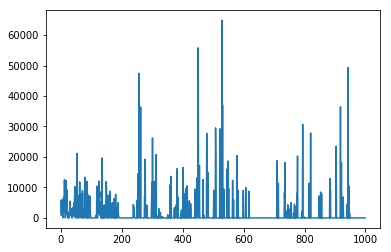

In [16]:
plt.figure()
plt.plot(range(len(losses)),losses)
plt.show()

In [15]:
torch.save(net.state_dict(),'./myC3D.pickle')

In [11]:
net.eval()
device=torch.device('cuda:1')
net.to(device)

C3D(
  (features): Sequential(
    (0): Conv3d(3, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (1): ReLU(inplace)
    (2): MaxPool3d(kernel_size=(1, 2, 2), stride=(1, 2, 2), padding=0, dilation=1, ceil_mode=False)
    (3): Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (4): ReLU(inplace)
    (5): MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2), padding=0, dilation=1, ceil_mode=False)
    (6): Conv3d(128, 256, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (7): ReLU(inplace)
    (8): Conv3d(256, 256, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (9): ReLU(inplace)
    (10): MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2), padding=0, dilation=1, ceil_mode=False)
    (11): Conv3d(256, 512, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (12): ReLU(inplace)
    (13): Conv3d(512, 512, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (14): ReLU(inplace)
    (15): MaxP

In [12]:

# testY=torch.from_numpy(np.array(testY)).type(torch.LongTensor)
testX=torch.from_numpy(np.array(testX)).type(torch.float)

In [15]:
torch.cuda.empty_cache()
gc.collect()
testX = Variable(testX)
testX = testX.cuda(1)

testLoss=[]
predictions=[]
for i in range(0,len(testX),1):
    
    prediction = net.predict(testX[i:i+1])
    print(prediction)
    print(testY[i])
    print()
    predictions.append(prediction.data.cpu().numpy())
    #print(Variable(prediction))
    #print(Variable(y))
#     loss = criterion(prediction,testY[i:i+2].squeeze())
#     testLoss.append(loss.item())

#     print(d,loss.item())


tensor([0])
[0]
tensor([0])
[1]
tensor([0])
[1]
tensor([0])
[1]
tensor([0])
[0]
tensor([0])
[0]
tensor([0])
[0]
tensor([0])
[0]
tensor([0])
[1]
tensor([0])
[0]
tensor([0])
[1]
tensor([0])
[0]
tensor([0])
[1]
tensor([0])
[1]
tensor([0])
[0]
tensor([0])
[1]
tensor([0])
[0]
tensor([0])
[0]
tensor([0])
[1]
tensor([0])
[0]
tensor([0])
[0]
tensor([0])
[1]
tensor([0])
[1]
tensor([0])
[1]
tensor([0])
[1]
tensor([0])
[1]
tensor([0])
[1]
tensor([0])
[0]
tensor([0])
[0]
tensor([0])
[1]
tensor([0])
[0]
tensor([0])
[1]
tensor([0])
[0]
tensor([0])
[0]
tensor([0])
[1]
tensor([0])
[1]
tensor([0])
[0]
tensor([0])
[1]
tensor([0])
[1]
tensor([0])
[1]
tensor([0])
[1]
tensor([0])
[0]
tensor([0])
[0]
tensor([0])
[1]
tensor([0])
[0]
tensor([0])
[1]
tensor([0])
[1]
tensor([0])
[0]
tensor([0])
[1]
tensor([0])
[0]
tensor([0])
[1]
tensor([0])
[1]
tensor([0])
[1]
tensor([0])
[1]
tensor([0])
[1]
tensor([0])
[0]
tensor([0])
[1]
tensor([0])
[1]
tensor([0])
[1]
tensor([0])
[1]
tensor([0])
[0]
tensor([0])
[0]
tensor([

In [14]:
print(len(predictions))
error = 0
for i in range(len(predictions)):
    if predictions[i]!=testY[i]:
        error+=1
print(error/len(predictions))
 

332
0.49698795180722893


In [ ]:
plt.figure()
plt.plot(range(len(predictions)),predictions-testY.data.cpu().numpy(),'ro')
# plt.plot(range(len(testY)),,'bx')

plt.show()